In [ ]:
import torch
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
import datasets


In [2]:
data = datasets.load_dataset("wmt/wmt14", data_dir="de-en")
data

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4508785
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

In [3]:
train = data["train"]
train

Dataset({
    features: ['translation'],
    num_rows: 4508785
})

In [4]:
train[0]

{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode',
  'en': 'Resumption of the session'}}

In [19]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("cyberagent/calm2-7b-chat")


In [6]:
train[0:5]["translation"]

[{'de': 'Wiederaufnahme der Sitzungsperiode',
  'en': 'Resumption of the session'},
 {'de': 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.',
  'en': 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.'},
 {'de': 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.',
  'en': "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."},
 {'de': 'Im Parlament besteht der Wunsch nach einer Aussprache im

In [7]:
def tokenize_fn(sample):
    en_inputs = tokenizer(sample["translation"]["en"])
    de_inputs = tokenizer(sample["translation"]["de"])

    return {"en_inputs": en_inputs, "de_inputs": de_inputs}
train_tokens = train.map(tokenize_fn, batched=True)
train_tokens

Map:   0%|                                                                          | 0/4508785 [00:00<?, ? examples/s]


TypeError: list indices must be integers or slices, not str

When using the batched in the datasets.Dataset object, the result is the key inside a list with each sample. However, in this case we have that "translation" is the first key so inside is a list with the respective keys. Instead of having {'de': ['sample1', 'sample2', ...], 'en': ['sample1', 'sample2', ...]}, we have the result above which means we need to loop again the samples inside the batch. So we use the dataloader collator to solve the problem, as pytorch doesn't group by keys like datasets.

In [5]:
from torch.utils.data import default_collate
def collate_fn(batch):
    batch = default_collate(batch)

    inputs = tokenizer(batch["translation"]["en"],  max_length=64, padding="longest", truncation=True, return_tensors="pt")
    outputs = tokenizer(batch["translation"]["de"],  max_length=64, padding="longest", truncation=True, return_tensors="pt")

    return {"en": inputs, "de": outputs}

In [12]:
conf = {"hidden_dim": 512, "vocabulary_size": 64543+1, "num_heads": 8, "intermediate_dim": 2048, "eps": 1e-06, "num_layers": 6, "dropout": 0.1,
            "label_smoothing": 0.1, "warmup_steps": 4000}
train_loader = DataLoader(train, batch_size=4, collate_fn=collate_fn)

In [13]:
from transformer_implementation import transformer

model = transformer(conf)
model.embeddings.vocabulary_size

64544

In [15]:
for batch in train_loader:
    print(batch["en"]["input_ids"])
    
    outputs, loss = model(batch["en"]["input_ids"], batch["de"]["input_ids"], batch["en"]["attention_mask"], batch["de"]["attention_mask"])

    print(outputs.shape)
    print(loss)
    break

tensor([[ 3101, 50278,   295,   262, 13703,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [   42, 37801, 42998,   262, 13703,   295,   262,  5530,  9945, 17748,
          3033,   282,   426, 11495,   208,    18,    24,  3615,   208,    18,
            26,    26,    26,    13,   309,   390,  1517,  2052,  6031,  1963,
           315, 19252,  1037,   253, 16607,  1240,  1144,   296,   262, 11437,
           484,  1037, 21179,   253, 62802, 22492,   667,  4363,    15],
        [17321,    13,   465,  1037,  1275,   917,  6019,    13,   262,   314,
          2398,   282,   665, 28136, 38810, 43718,     8,  9651,   315,  8249,
          1812,    13,  3342,   262,  1439,   296,   253,  2548,

In [48]:
import torch.nn as nn
embedds = nn.Embedding(62802+1, 512)

embedds(batch["en"]["input_ids"])

tensor([[[-0.6915,  0.9373, -0.9112,  ...,  1.2188, -0.3707, -0.1835],
         [ 1.7822,  0.8697, -0.6574,  ..., -0.0116, -0.7022, -0.1988],
         [-0.7137,  0.3702, -1.1199,  ..., -0.7879,  2.0542, -0.0955],
         ...,
         [ 0.6590, -0.2312, -0.0916,  ...,  0.3088, -1.5308, -2.2032],
         [ 0.6590, -0.2312, -0.0916,  ...,  0.3088, -1.5308, -2.2032],
         [ 0.6590, -0.2312, -0.0916,  ...,  0.3088, -1.5308, -2.2032]],

        [[-0.1726, -0.0534,  0.8824,  ..., -2.4328,  0.5319, -0.7416],
         [-0.1270, -1.1826,  2.5968,  ...,  0.8937, -0.3032, -0.7836],
         [ 1.6497,  0.3885,  0.6099,  ...,  0.5231,  0.3801, -0.7532],
         ...,
         [-1.3986, -1.2340, -0.4023,  ...,  1.3714, -0.4594, -0.0738],
         [ 0.8796,  0.1146,  0.5505,  ...,  0.9200,  0.4023, -0.2889],
         [ 0.9514, -0.4512, -0.0806,  ...,  0.8243,  1.0599, -1.2889]],

        [[ 1.9499, -0.6936, -0.0541,  ..., -0.2275,  0.3371, -0.4754],
         [ 0.4063,  0.1983, -1.8441,  ...,  1

nn.Embedding needs to have the same vocabulary size than the tokenizer, is not necessary to add 1 more.

In [10]:
for batch in loader:
    print(batch)
    print("*"*10)
    print(batch["translation"]["de"])
    print(tokenizer(batch["translation"]["en"], max_length=512, padding="longest"))
    break

{'translation': {'de': ['Wiederaufnahme der Sitzungsperiode', 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.', 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.', 'Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.'], 'en': ['Resumption of the session', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.', "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disaster

In [11]:
attention_mask = torch.tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
attention_mask.shape
attention_mask = (1-attention_mask) * torch.finfo(torch.float16).min
print(attention_mask)

tensor([[    -0.,     -0.,     -0.,     -0.,     -0., -65504., -65504., -65504.,
         -65504., -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
         -65504., -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
         -65504., -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
         -65504., -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
         -65504., -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
         -65504.],
        [    -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
             -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
             -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
             -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
             -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
             -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,     -0.,
         

In [12]:
def make_causal_mask(input_ids_shape, dtype, target_padding_mask, context_length=0):
    batch_size, seq_length = input_ids_shape
    
    # lower diagonal matrix as we want to use the first token in the first sentence
    # there are several ways of computing the mask
    # attention_mask = torch.tril(torch.ones((seq_length, context_length)))
    
    # attention_mask = (1 - attention_mask) * torch.finfo(dtype).min

    # the first mask is just the causal one, without taking into account the context or pass values
    mask = torch.full((seq_length, seq_length), torch.finfo(dtype).min)
    
    mask_cond = torch.arange(mask.size(-1))
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    # print(mask)
    # tensor([[ 1], [ 2], [ 3]])
    
    if context_length > 0:
        mask = torch.cat([torch.zeros(seq_length, context_length), mask], dim=-1)
    
    print(mask.shape)
    mask = mask[None, :, :].expand(batch_size, seq_length, seq_length+context_length)
    # the target_padding_mask has ones for the places to attend and 0 for the padding
    print(mask.shape)
    # mask = mask.logical_or(target_padding_mask.unsqueeze(1))

    return mask.unsqueeze(1)


In [13]:
attention_mask = torch.tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
print(attention_mask.shape)
make_causal_mask(input_ids_shape=attention_mask.shape, dtype=torch.float16, target_padding_mask=attention_mask)

torch.Size([2, 49])
torch.Size([49, 49])
torch.Size([2, 49, 49])


tensor([[[[     0., -65504., -65504.,  ..., -65504., -65504., -65504.],
          [     0.,      0., -65504.,  ..., -65504., -65504., -65504.],
          [     0.,      0.,      0.,  ..., -65504., -65504., -65504.],
          ...,
          [     0.,      0.,      0.,  ...,      0., -65504., -65504.],
          [     0.,      0.,      0.,  ...,      0.,      0., -65504.],
          [     0.,      0.,      0.,  ...,      0.,      0.,      0.]]],


        [[[     0., -65504., -65504.,  ..., -65504., -65504., -65504.],
          [     0.,      0., -65504.,  ..., -65504., -65504., -65504.],
          [     0.,      0.,      0.,  ..., -65504., -65504., -65504.],
          ...,
          [     0.,      0.,      0.,  ...,      0., -65504., -65504.],
          [     0.,      0.,      0.,  ...,      0.,      0., -65504.],
          [     0.,      0.,      0.,  ...,      0.,      0.,      0.]]]])

In [14]:
mask = make_causal_mask(input_ids_shape=(1, 16), dtype=torch.float16, target_padding_mask=attention_mask)
mask

torch.Size([16, 16])
torch.Size([1, 16, 16])


tensor([[[[     0., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504.],
          [     0.,      0., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504.],
          [     0.,      0.,      0., -65504., -65504., -65504., -65504.,
           -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504.],
          [     0.,      0.,      0.,      0., -65504., -65504., -65504.,
           -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504.],
          [     0.,      0.,      0.,      0.,      0., -65504., -65504.,
           -65504., -65504., -65504., -65504., -65504., -65504., -65504.,
           -65504., -65504.],
          [     0.,      0.,      0.,      0.,      0.,      0., -65504.,
           -65504., -65504., -65504.

In [15]:
attn_mask = torch.cat([torch.ones(8), torch.zeros(8)])
attn_mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
attn_mask.expand(1, 1, mask.shape[2], mask.shape[2]), attn_mask.expand(1, 1, mask.shape[2], mask.shape[2]).shape, mask.shape

(tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
           [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],

In [17]:

mask + (1 - attn_mask.expand(1, 1, mask.shape[2], mask.shape[2])) * torch.finfo(torch.float16).min

tensor([[[[      0.,  -65504.,  -65504.,  -65504.,  -65504.,  -65504.,  -65504.,
            -65504., -131008., -131008., -131008., -131008., -131008., -131008.,
           -131008., -131008.],
          [      0.,       0.,  -65504.,  -65504.,  -65504.,  -65504.,  -65504.,
            -65504., -131008., -131008., -131008., -131008., -131008., -131008.,
           -131008., -131008.],
          [      0.,       0.,       0.,  -65504.,  -65504.,  -65504.,  -65504.,
            -65504., -131008., -131008., -131008., -131008., -131008., -131008.,
           -131008., -131008.],
          [      0.,       0.,       0.,       0.,  -65504.,  -65504.,  -65504.,
            -65504., -131008., -131008., -131008., -131008., -131008., -131008.,
           -131008., -131008.],
          [      0.,       0.,       0.,       0.,       0.,  -65504.,  -65504.,
            -65504., -131008., -131008., -131008., -131008., -131008., -131008.,
           -131008., -131008.],
          [      0.,       0.,

In [22]:
def make_causal_mask(input_ids_shape, dtype, target_padding_mask, context_length=0):
    batch_size, seq_length = input_ids_shape
    
    # lower diagonal matrix as we want to use the first token in the first sentence
    # there are several ways of computing the mask
    # attention_mask = torch.tril(torch.ones((seq_length, context_length)))
    
    # attention_mask = (1 - attention_mask) * torch.finfo(dtype).min

    # the first mask is just the causal one, without taking into account the context or pass values
    mask = torch.full((seq_length, seq_length), 0)
    
    mask_cond = torch.arange(mask.size(-1))
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 1)
    # print(mask)
    # tensor([[ 1], [ 2], [ 3]])
    
    if context_length > 0:
        mask = torch.cat([torch.zeros(seq_length, context_length), mask], dim=-1)
    
    print(mask.shape)
    mask = mask[None, :, :].expand(batch_size, seq_length, seq_length+context_length)
    # the target_padding_mask has ones for the places to attend and 0 for the padding
    print(mask.shape)
    # mask = mask.logical_or(target_padding_mask.unsqueeze(1))

    return mask.unsqueeze(1)


In [23]:
mask = make_causal_mask(input_ids_shape=(1, 16), dtype=torch.float16, target_padding_mask=attention_mask)
mask

torch.Size([16, 16])
torch.Size([1, 16, 16])


tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])

In [24]:
mask + (1 - attn_mask.expand(1, 1, mask.shape[2], mask.shape[2])) * torch.finfo(torch.float16).min

tensor([[[[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00, -6.5504e+04, -6.5504e+04,
           -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04,
           -6.5504e+04],
          [ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00, -6.5504e+04, -6.5504e+04,
           -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04,
           -6.5504e+04],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00, -6.5504e+04, -6.5504e+04,
           -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04,
           -6.5504e+04],
          [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00, -6.5504e+04, -6.5504e+04,
           -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04, -6.5504e+04,
           -6

In [25]:
mask.logical_or(attn_mask)

tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False,
           False, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  T

## Masks taking into account padding

In [2]:
import torch

def create_causal_mask_with_padding_mult(seq_len, padding_mask, device):
    """
    Creates a causal mask with padding taken into account.

    Args:
        seq_len (int): The length of the sequence.
        padding_mask (torch.Tensor): A tensor of shape (batch_size, seq_len) with 0 where padding is present and 1 otherwise.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 1, seq_len, seq_len) representing the causal mask with padding.
    """
    # Create a causal mask
    causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.float32, device=device))

    # Combine with padding mask
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
    combined_mask = causal_mask.unsqueeze(0) * padding_mask

    combined_mask = (1-combined_mask) * torch.finfo(torch.float32).min

    return combined_mask

# Example usage
device = "cuda"
seq_len = 5
batch_size = 2
padding_mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 0, 0, 0]], dtype=torch.bool, device=device)

causal_mask_with_padding = create_causal_mask_with_padding_mult(seq_len, padding_mask, "cuda")
print(causal_mask_with_padding)


tensor([[[[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38]]],


        [[[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38]]]],
       device='cuda:0')


In [3]:
import torch

def create_causal_mask_with_padding_sum(seq_len, padding_mask, device):
    """
    Creates a causal mask with padding taken into account using summation.

    Args:
        seq_len (int): The length of the sequence.
        padding_mask (torch.Tensor): A tensor of shape (batch_size, seq_len) with 0 where padding is present and 1 otherwise.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 1, seq_len, seq_len) representing the causal mask with padding.
    """
    # Create a causal mask with very high negative values
    causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.float32, device=device), diagonal=1).unsqueeze(0)
    causal_mask = causal_mask.masked_fill(causal_mask == 1, torch.finfo(torch.float32).min)

    # Create a padding mask with very high negative values
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
    padding_mask = padding_mask.float().masked_fill(padding_mask == 0, torch.finfo(torch.float32).min).masked_fill(padding_mask == 1, 0.0)
    # Combine the causal mask and the padding mask
    combined_mask = causal_mask + padding_mask

    return combined_mask

# Example usage
seq_len = 5
batch_size = 2
padding_mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 0, 0, 0]], dtype=torch.bool).to("cuda")

causal_mask_with_padding = create_causal_mask_with_padding_sum(seq_len, padding_mask, "cuda")
print(causal_mask_with_padding)


tensor([[[[ 0.0000e+00, -3.4028e+38, -3.4028e+38,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.4028e+38,        -inf],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.4028e+38, -3.4028e+38]]],


        [[[ 0.0000e+00, -3.4028e+38,        -inf,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00,        -inf,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38,        -inf,        -inf],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38, -3.4028e+38,        -inf],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38]]]],
       device='cuda:0')


In [11]:
import time
import torch
import numpy as np
torch.cuda.empty_cache()
def measure_time(func, *args, repeats=400):
    times = []
    for _ in range(repeats):
        start = time.time()
        func(*args)
        end = time.time()
        times.append(end - start)
    return np.mean(times)

device = "cuda"
# Example parameters
seq_len = 3800
batch_size = 32
padding_mask = []
for i in range(batch_size):
    num = np.random.randint(10, 500)
    padding_mask.append(torch.cat([torch.ones(num), torch.zeros(seq_len-num)]))
# padding_mask = torch.randint(0, 2, (batch_size, seq_len), dtype=torch.bool)
padding_mask = torch.stack(padding_mask, dim=0).to(device)

# Measure the time taken for each function
with torch.no_grad():
    time_mult = measure_time(create_causal_mask_with_padding_mult, seq_len, padding_mask, device)
    time_sum = measure_time(create_causal_mask_with_padding_sum, seq_len, padding_mask, device)

print(f"Multiplication approach average time: {time_mult:.6f} seconds")
print(f"Summation approach average time: {time_sum:.6f} seconds")


Multiplication approach average time: 0.000100 seconds
Summation approach average time: 0.045313 seconds


In [12]:
torch.cuda.empty_cache()

In [13]:
torch.cuda.empty_cache()

# Example parameters
seq_len = 512
batch_size = 16
padding_mask = []
for i in range(batch_size):
    num = np.random.randint(10, 500)
    padding_mask.append(torch.cat([torch.ones(num), torch.zeros(seq_len-num)]))
# padding_mask = torch.randint(0, 2, (batch_size, seq_len), dtype=torch.bool)
padding_mask = torch.stack(padding_mask, dim=0).to(device)

# Measure the time taken for each function
with torch.no_grad():
    time_mult = measure_time(create_causal_mask_with_padding_mult, seq_len, padding_mask, device)
    time_sum = measure_time(create_causal_mask_with_padding_sum, seq_len, padding_mask, device)

print(f"Multiplication approach average time: {time_mult:.6f} seconds")
print(f"Summation approach average time: {time_sum:.6f} seconds")


Multiplication approach average time: 0.000062 seconds
Summation approach average time: 0.001215 seconds


In [15]:
padding_mask.shape, padding_mask[0]

(torch.Size([16, 512]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

Using the GPU the Multiplication  approach is really fast, almost 4 times faster.

In [18]:
torch.tril(torch.ones((6, 6)))

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

## Analysis

In [2]:
import torch
import datasets

data = datasets.load_dataset("wmt/wmt14", data_dir="de-en")
data

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4508785
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

In [6]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file(r"TOKENIZER-PATH")
tokenizer

In [8]:
tokenizer.model

In [7]:
tokenizer.tokenize("In this tour, we will build and train a Byte-Pair Encoding (BPE) tokenizer. For more information about the different type of tokenizers, check out this guide in the 🤗 Transformers documentation. Here, training the tokenizer means it will learn merge rules by:")

AttributeError: 'tokenizers.Tokenizer' object has no attribute 'tokenize'

The tokenizer object from tokenizers is not the same as the one from transformers, so it doesn't have the usual methods. Then we just load the file to a PreTrainedTokenizerFast from transformers.

In [9]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"TOKENIZER-PATH")


In [10]:
fast_tokenizer.tokenize("In this tour, we will build and train a Byte-Pair Encoding (BPE) tokenizer. For more information about the different type of tokenizers, check out this guide in the 🤗 Transformers documentation. Here, training the tokenizer means it will learn merge rules by:")

['In',
 'this',
 'tour',
 ',',
 'we',
 'will',
 'build',
 'and',
 'train',
 'a',
 'By',
 'te',
 '-',
 'P',
 'air',
 'En',
 'coding',
 '(',
 'B',
 'PE',
 ')',
 'to',
 'ken',
 'izer',
 '.',
 'For',
 'more',
 'information',
 'about',
 'the',
 'different',
 'type',
 'of',
 'to',
 'ken',
 'izers',
 ',',
 'check',
 'out',
 'this',
 'guide',
 'in',
 'the',
 '[UNK]',
 'Trans',
 'form',
 'ers',
 'documentation',
 '.',
 'Here',
 ',',
 'training',
 'the',
 'to',
 'ken',
 'izer',
 'means',
 'it',
 'will',
 'learn',
 'mer',
 'ge',
 'rules',
 'by',
 ':']

100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:47<00:00, 10576.72it/s]


Mean Tokens: 29.836778
Mode of lengths: [(21, 14003)]


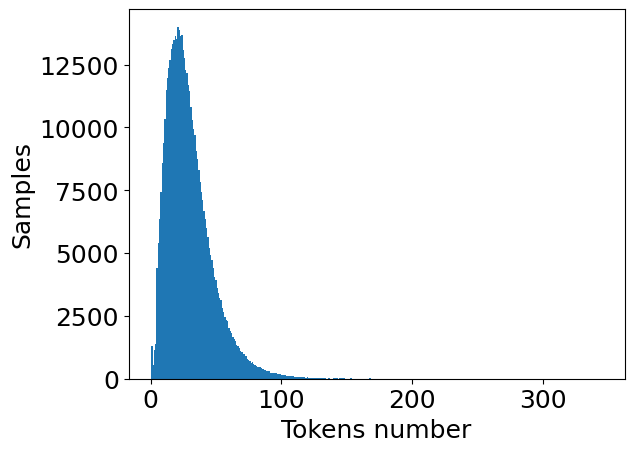

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:00<00:00, 8212.78it/s]


Mean Tokens: 29.716964
Mode of lengths: [(19, 13658)]


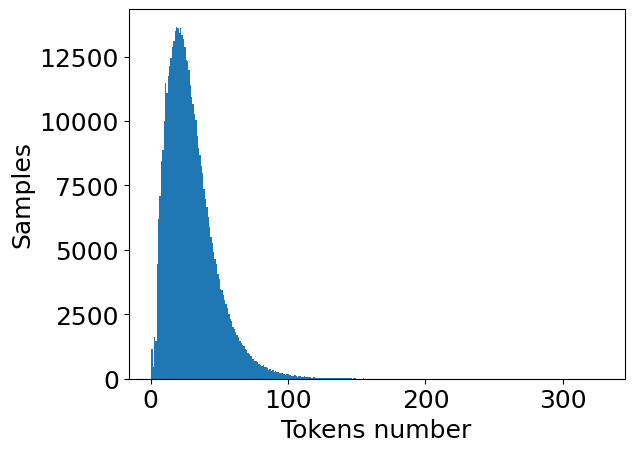

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18 # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset, column: str):
  """データセット中のテキストのトークン数の分布をグラフとして描画"""
  # データセット中のテキストの長さを数える
  length_counter = Counter()
  total = 0
  for data in tqdm(dataset):
    length = len(fast_tokenizer.tokenize(data['translation'][column]))
    length_counter[length] += 1
    total += length

  print(f"Mean Tokens: {total/len(dataset)}")
  print(f"Mode of lengths: {length_counter.most_common(1)}")
  # length_counterの地から棒グラフを描画する
  plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
  plt.xlabel("Tokens number")
  plt.ylabel("Samples")
  plt.show()

train = data["train"].select(range(0, 500000))

visualize_text_length(train, "en")
visualize_text_length(train, "de")


We can see that setting the max_length to 256 is good enough. Probably it would be better to use 128.

In [18]:
fast_tokenizer("[PAD]"), fast_tokenizer.eos_token

({'input_ids': [3], 'token_type_ids': [0], 'attention_mask': [1]}, None)

In [21]:
tokenizer.eos_token, tokenizer.pad_token

('<|endoftext|>', '<|padding|>')

## bentrevett/multi30k

In [1]:
import torch
import datasets
data = datasets.load_dataset("bentrevett/multi30k", split="train")
data

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
})

In [2]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"TOKENIZER-PATH")


In [5]:
data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

100%|██████████████████████████████████████████████████████████████████████████| 29000/29000 [00:03<00:00, 9471.41it/s]


Mean Tokens: 13.154758620689655
Mode of lengths: [(11, 3299)]


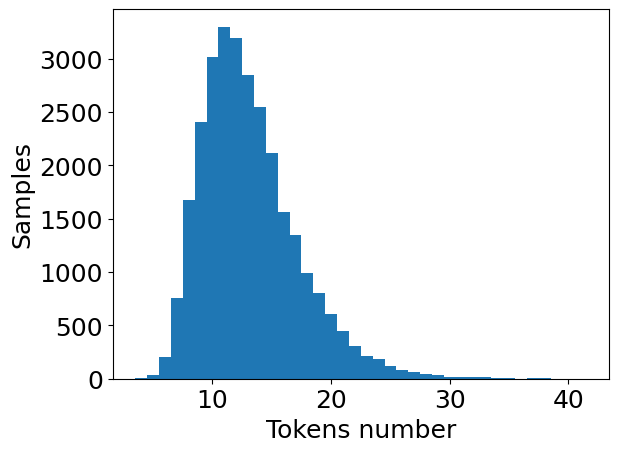

100%|██████████████████████████████████████████████████████████████████████████| 29000/29000 [00:03<00:00, 8350.46it/s]


Mean Tokens: 12.708827586206896
Mode of lengths: [(11, 3158)]


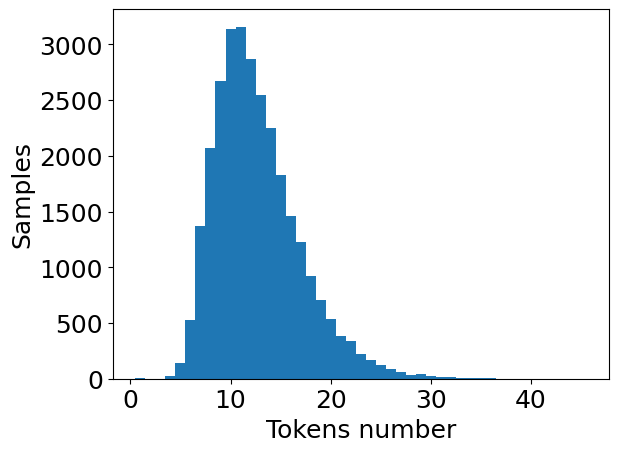

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18 # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset, column: str):
  """データセット中のテキストのトークン数の分布をグラフとして描画"""
  # データセット中のテキストの長さを数える
  length_counter = Counter()
  total = 0
  for data in tqdm(dataset):
    length = len(fast_tokenizer.tokenize(data[column]))
    length_counter[length] += 1
    total += length

  print(f"Mean Tokens: {total/len(dataset)}")
  print(f"Mode of lengths: {length_counter.most_common(1)}")
  # length_counterの地から棒グラフを描画する
  plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
  plt.xlabel("Tokens number")
  plt.ylabel("Samples")
  plt.show()


visualize_text_length(data, "en")
visualize_text_length(data, "de")


This dataset is incredibly sort, using max 64 we cover all the samples, even using max 32 shouldn't be a problem.

## Plot loss

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

df = pd.read_csv(r"LOGS-PATH")
df

,Unnamed: 0,step,train_loss,val_loss
0,0,1001,8962.159678,27698.496784
1,1,2001,6634.219767,4984.716454
2,2,3001,6154.298130,5981.841901
3,3,4001,6981.732652,5790.449637
4,4,5001,6649.675571,5653.439184
...,...,...,...,...
195,195,196001,5372.130030,4813.936297
196,196,197001,5364.532682,4942.179702
197,197,198001,5390.537009,4806.870880
198,198,199001,5344.896405,4750.358171


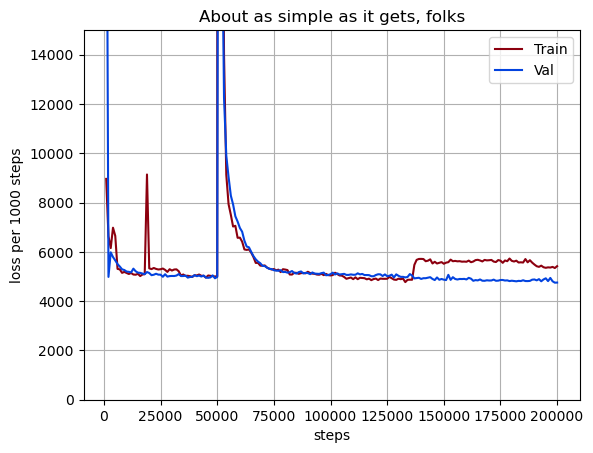

In [16]:
fig, ax = plt.subplots()
ax.plot(df["step"], df["train_loss"], 'xkcd:crimson', label='Train')
ax.plot(df["step"], df["val_loss"], 'xkcd:blue', label='Val')
ax.set(xlabel='steps', ylabel='loss per 1000 steps',
       title='About as simple as it gets, folks')
ax.grid()
ax.set_ylim(ymin=0, ymax=15000)
ax.legend()
plt.show()

Here we can see the famous loss spikes that often occur in LLM pretraining. This model was trained without using special tokens so it works really bad. It always predict the same tokens despite the input, it predicts the padding token a lot, but the dataset has the padding="longest" so the padding shouldn't be so huge. For better pretraining, grouping batches by length could be a better option.

# Debug model

In [1]:
import torch
from transformer_implementation import transformer
from transformers import PreTrainedTokenizerFast
import numpy as np

In [2]:
np.random.seed(46)
torch.manual_seed(46)
# change dropout to 0
conf = {"hidden_dim": 512, "vocabulary_size": 12000, "num_heads": 8, "intermediate_dim": 2048, "eps": 1e-06, "num_layers": 6, "dropout": 0.0,
            "label_smoothing": 0.1, "warmup_steps": 4000, "max_length": 128}
device = "cuda"

tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"TOKENIZER-PATH")
tokenizer.pad_token = "[PAD]"
tokenizer.eos_token = "[PAD]"
conf["vocabulary_size"] = tokenizer.vocab_size + 1
model = transformer(conf).to(device)
net_weights = torch.load(r'weights\transformer_200001.pth',
                         map_location={'cuda:0': 'cpu'})

model.load_state_dict(net_weights)
model.eval()
print('ネットワーク設定完了：学習済みの重みをロードしました')

text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt")
print(inputs)
inputs = {k: v.to(device) for k, v in inputs.items()}
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt")
print(target_tokens["input_ids"][0][0])


ネットワーク設定完了：学習済みの重みをロードしました
{'input_ids': tensor([[ 4965,    16,  3228,  3165,  3904,  3485,  3364,    69, 24221,  5519,
          3281,  4897,  3193,  3178,  3608,  3188,  3228,  3389,  3332,  3364,
          3193,  6094,  3281,  7184,  3391,  5694,  3410,  3190,  3178,  3608,
            18]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}
tensor(5485)


In [3]:
with torch.no_grad():
    target_tokens = {k: v.to(device) for k, v in target_tokens.items()}

    logits, loss, last_hidden_states, attentions_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True)


In [4]:
last_hidden_states.shape

torch.Size([1, 27, 512])

In [5]:
diffs = []
for i in range(len(last_hidden_states)):
    gap = 0
    for j in range(len(last_hidden_states)):
        if j == i:
            gap += abs(last_hidden_states[i] - last_hidden_states[j])
    diffs.append(gap)
print(f"Difference between each hidden state: {diffs}")


Difference between each hidden state: [tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')]


In [6]:
last_hidden_states[0][0] == last_hidden_states[0][-1]

tensor([False, False, False,  True,  True, False, False, False, False, False,
         True,  True, False,  True,  True, False,  True, False,  True, False,
        False,  True,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False,  True, False,  True, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
         True, False, False, False, False, False, False, False, False,  True,
         True,  True,  True, False, False, False, False, False, False,  True,
         True,  True, False, False,  True,  True, False,  True, False,  True,
        False, False, False,  True, False, False, False,  True, False,  True,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, 

In [13]:
last_hidden_states[0][0][0:25], last_hidden_states[0][-1][0:25]

(tensor([-0.0032,  0.0026, -0.0040,  0.0268, -0.0002,  0.0214,  0.0047,  0.0058,
         -0.0439, -0.0011,  0.0139, -0.0227, -0.0268,  0.0010,  0.0111,  0.0048,
         -0.0093,  0.0004, -0.0137, -0.0081,  0.0061,  0.0058, -0.0419,  0.0040,
          0.0036], device='cuda:0'),
 tensor([-0.0032,  0.0026, -0.0040,  0.0268, -0.0002,  0.0214,  0.0047,  0.0058,
         -0.0439, -0.0011,  0.0139, -0.0227, -0.0268,  0.0010,  0.0111,  0.0048,
         -0.0093,  0.0004, -0.0137, -0.0081,  0.0061,  0.0058, -0.0419,  0.0040,
          0.0036], device='cuda:0'))

In [16]:
(last_hidden_states[0][0] - last_hidden_states[0][-1])[:20]

tensor([ 2.7940e-09, -2.3283e-10, -4.6566e-10,  0.0000e+00,  0.0000e+00,
         1.8626e-09, -4.6566e-10,  4.6566e-09,  2.9802e-08, -1.1642e-09,
         0.0000e+00,  0.0000e+00,  1.4901e-08,  0.0000e+00,  0.0000e+00,
        -7.4506e-09,  0.0000e+00,  4.6566e-10,  0.0000e+00,  2.7940e-09],
       device='cuda:0')

In [23]:
torch.finfo(torch.float32).eps

1.1920928955078125e-07

The difference between the hidden state of the token 0 and the hidden state of the last token, 27 is minimal. Almost equal to eps so it is the same value. This means that as all the hidden states are the same for all the tokens, then all the tokens will predict the same next token.

In [18]:
len(attentions_array), attentions_array[0].shape

(6, torch.Size([1, 8, 27, 27]))

In [17]:
diffs = []
for i in range(len(attentions_array)):
    gap = 0
    for j in range(len(attentions_array)):
        if j == i:
            gap += abs(attentions_array[i] - attentions_array[j])
    diffs.append(torch.sum(gap))
    
print(f"Difference between each attention layer: {diffs}")
print(attentions_array[0][0].shape)

Difference between each attention layer: [tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0')]
torch.Size([8, 27, 27])


In [22]:
torch.sum(attentions_array[0][0] - attentions_array[0][-1])

tensor(0., device='cuda:0')

In [25]:
attentions_array[0][-1][0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+

In [26]:
attentions_array[0][0][0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+

The attention is always the same for all layers, there are 6 of them, also the attention only attends 1 token, the rest of them are 0.

## Gradients

In [1]:
import torch
from transformer_implementation import transformer
from transformers import PreTrainedTokenizerFast
import numpy as np

In [3]:
np.random.seed(46)
torch.manual_seed(46)
# change dropout to 0
conf = {"hidden_dim": 512, "vocabulary_size": 12000, "num_heads": 8, "intermediate_dim": 2048, "eps": 1e-06, "num_layers": 6, "dropout": 0.0,
            "label_smoothing": 0.1, "warmup_steps": 4000, "max_length": 128}
device = "cuda"

tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"TOKENIZER-PATH")
tokenizer.pad_token = "[PAD]"
tokenizer.eos_token = "[PAD]"
conf["vocabulary_size"] = tokenizer.vocab_size + 1
model = transformer(conf).to(device)
net_weights = torch.load(r'weights\transformer_200001.pth',
                         map_location={'cuda:0': 'cpu'})

model.load_state_dict(net_weights)
model.train()
print('ネットワーク設定完了：学習済みの重みをロードしました')

text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt")
print(inputs)
inputs = {k: v.to(device) for k, v in inputs.items()}
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt")
print(target_tokens["input_ids"][0][0])


ネットワーク設定完了：学習済みの重みをロードしました
{'input_ids': tensor([[ 4965,    16,  3228,  3165,  3904,  3485,  3364,    69, 24221,  5519,
          3281,  4897,  3193,  3178,  3608,  3188,  3228,  3389,  3332,  3364,
          3193,  6094,  3281,  7184,  3391,  5694,  3410,  3190,  3178,  3608,
            18]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}
tensor(5485)


In [5]:
target_tokens = {k: v.to(device) for k, v in target_tokens.items()}

logits, loss, last_hidden_states, attentions_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True)
loss.backward()

In [11]:
for p in model.decoder.layers[0].msha.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

tensor([[ 4.4222e-23, -7.8010e-23,  1.4004e-23,  ..., -1.5780e-22,
          3.5816e-23, -2.5326e-23],
        [ 3.2381e-23, -5.7121e-23,  1.0254e-23,  ..., -1.1555e-22,
          2.6225e-23, -1.8544e-23],
        [ 4.0516e-23, -7.1472e-23,  1.2830e-23,  ..., -1.4457e-22,
          3.2814e-23, -2.3203e-23],
        ...,
        [-6.9996e-24,  1.1420e-23, -7.2587e-25,  ...,  2.4532e-23,
         -4.0490e-24,  1.7862e-24],
        [-5.9758e-24,  9.7499e-24, -6.1970e-25,  ...,  2.0944e-23,
         -3.4568e-24,  1.5249e-24],
        [-6.6272e-24,  1.0813e-23, -6.8725e-25,  ...,  2.3226e-23,
         -3.8336e-24,  1.6912e-24]], device='cuda:0')
tensor(5.8476e-22, device='cuda:0')
tensor(-6.4372e-22, device='cuda:0')


In [12]:
for p in model.decoder.layers[-1].msha.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

tensor([[ 5.4658e-10, -4.5591e-11,  1.1193e-10,  ...,  3.7838e-10,
          4.4778e-10,  1.1224e-09],
        [ 1.5914e-12, -1.3219e-13,  3.2679e-13,  ...,  1.1060e-12,
          1.3070e-12,  3.2759e-12],
        [-3.8044e-10,  3.1731e-11, -7.7909e-11,  ..., -2.6338e-10,
         -3.1169e-10, -7.8123e-10],
        ...,
        [ 1.5713e-11, -1.3105e-12,  3.2179e-12,  ...,  1.0879e-11,
          1.2874e-11,  3.2267e-11],
        [-2.1817e-11,  1.8197e-12, -4.4679e-12,  ..., -1.5104e-11,
         -1.7874e-11, -4.4801e-11],
        [-9.9789e-14,  8.2987e-15, -2.0475e-14,  ..., -6.9277e-14,
         -8.1900e-14, -2.0527e-13]], device='cuda:0')
tensor(1.3156e-07, device='cuda:0')
tensor(-1.4555e-07, device='cuda:0')


In [13]:
for p in model.decoder.layers[0].ff.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

tensor([[ 7.6372e-15,  2.2751e-14, -1.7263e-15,  ..., -1.3385e-13,
          4.4513e-15,  5.2040e-14],
        [ 7.1496e-15,  4.4155e-14, -2.0232e-14,  ..., -3.6519e-13,
          2.6138e-14,  1.0284e-13],
        [-1.7326e-15, -1.0266e-16, -3.2942e-15,  ..., -3.1273e-14,
          4.3425e-15, -1.9105e-15],
        ...,
        [ 3.6985e-15,  4.0136e-14, -2.1064e-14,  ..., -3.4346e-13,
          2.4307e-14,  9.2783e-14],
        [-2.9488e-15, -2.7108e-15,  2.2210e-14,  ...,  2.4602e-13,
         -3.0732e-14, -2.5627e-15],
        [ 8.2309e-17,  5.5019e-15,  3.6725e-15,  ..., -6.9929e-16,
         -1.8842e-15,  2.2237e-15]], device='cuda:0')
tensor(2.9191e-12, device='cuda:0')
tensor(-3.7406e-12, device='cuda:0')


In [14]:
for p in model.decoder.layers[-1].ff.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.2214e-05, -1.3282e-06,  1.1118e-06,  ...,  8.8405e-06,
          7.3263e-06, -7.3647e-07]], device='cuda:0')
tensor(0.0381, device='cuda:0')
tensor(-0.0276, device='cuda:0')


The gradients in the ff of the last layer of the decoder are really low in general.

In [15]:
import torch.nn as nn
nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5, norm_type=2)

tensor(134.2164, device='cuda:0')

In [16]:
print("First layer msha gradients")
for p in model.decoder.layers[0].msha.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

print("Last layer msha gradients")
for p in model.decoder.layers[-1].msha.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

First layer msha gradients
tensor([[ 1.6474e-25, -2.9061e-25,  5.2170e-26,  ..., -5.8786e-25,
          1.3342e-25, -9.4348e-26],
        [ 1.2063e-25, -2.1279e-25,  3.8201e-26,  ..., -4.3044e-25,
          9.7697e-26, -6.9084e-26],
        [ 1.5093e-25, -2.6625e-25,  4.7798e-26,  ..., -5.3858e-25,
          1.2224e-25, -8.6440e-26],
        ...,
        [-2.6076e-26,  4.2544e-26, -2.7041e-27,  ...,  9.1388e-26,
         -1.5084e-26,  6.6541e-27],
        [-2.2262e-26,  3.6321e-26, -2.3086e-27,  ...,  7.8022e-26,
         -1.2878e-26,  5.6809e-27],
        [-2.4688e-26,  4.0281e-26, -2.5602e-27,  ...,  8.6526e-26,
         -1.4281e-26,  6.3001e-27]], device='cuda:0')
tensor(2.1784e-24, device='cuda:0')
tensor(-2.3981e-24, device='cuda:0')
Last layer msha gradients
tensor([[ 2.0362e-12, -1.6984e-13,  4.1697e-13,  ...,  1.4096e-12,
          1.6681e-12,  4.1811e-12],
        [ 5.9285e-15, -4.9245e-16,  1.2174e-15,  ...,  4.1203e-15,
          4.8692e-15,  1.2204e-14],
        [-1.4173e-1

In [17]:
print("First layer msha gradients")
for p in model.decoder.layers[0].ff.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

print("Last layer msha gradients")
for p in model.decoder.layers[-1].ff.parameters():
    print(p.grad)
    print(torch.max(p.grad))
    print(torch.min(p.grad))
    break

First layer msha gradients
tensor([[ 2.8451e-17,  8.4754e-17, -6.4311e-18,  ..., -4.9863e-16,
          1.6583e-17,  1.9386e-16],
        [ 2.6635e-17,  1.6449e-16, -7.5373e-17,  ..., -1.3605e-15,
          9.7374e-17,  3.8312e-16],
        [-6.4546e-18, -3.8245e-19, -1.2272e-17,  ..., -1.1650e-16,
          1.6177e-17, -7.1172e-18],
        ...,
        [ 1.3778e-17,  1.4952e-16, -7.8470e-17,  ..., -1.2795e-15,
          9.0552e-17,  3.4565e-16],
        [-1.0985e-17, -1.0099e-17,  8.2741e-17,  ...,  9.1650e-16,
         -1.1449e-16, -9.5470e-18],
        [ 3.0663e-19,  2.0496e-17,  1.3681e-17,  ..., -2.6051e-18,
         -7.0191e-18,  8.2839e-18]], device='cuda:0')
tensor(1.0874e-14, device='cuda:0')
tensor(-1.3935e-14, device='cuda:0')
Last layer msha gradients
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+0

Applying the gradient norm the gradients become smaller.

In [18]:
for p in model.decoder.layers[-1].ff.parameters():
    print(p)
    print(torch.max(p))
    print(torch.min(p))
    break

Parameter containing:
tensor([[ 0.8910, -0.0913,  0.7374,  ..., -0.1493,  0.8991,  0.5413],
        [ 1.3637,  0.4960,  0.1971,  ...,  0.5882,  0.6239, -1.2272],
        [ 6.3032, -1.8820,  3.1680,  ...,  1.1644,  5.5872, -0.7619],
        ...,
        [ 2.5317,  2.3459,  0.1695,  ...,  2.3445,  2.5316,  2.3382],
        [ 0.2184,  2.3405,  0.2014,  ...,  0.0253,  2.5082,  2.2938],
        [-0.5016,  0.2802, -0.3502,  ..., -0.1726, -0.6074,  0.1090]],
       device='cuda:0', requires_grad=True)
tensor(1915.1505, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1915.0142, device='cuda:0', grad_fn=<MinBackward1>)


## Lr scheduler

In [19]:
import bitsandbytes as bnb
from torch.optim.lr_scheduler import LRScheduler

optim = bnb.optim.AdamW8bit(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

class transformer_scheduler(LRScheduler):
    def __init__(self, optimizer, hidden_dim, warmup_steps, last_epoch=-1, verbose="deprecated") -> None:
        self.hidden_dim = hidden_dim
        self.warmup_steps = warmup_steps
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self) -> float:
        lr_rate = self.hidden_dim**(-0.5) * min(self._step_count**(-0.5), self._step_count*self.warmup_steps**(-1.5))
        return [lr_rate for group in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        lr_rate = self.hidden_dim**(-0.5) * min(self._step_count**(-0.5), self._step_count*self.warmup_steps**(-1.5))
        return [lr_rate for base_lr in self.base_lrs]

scheduler = transformer_scheduler(optim, conf["hidden_dim"], conf["warmup_steps"])


3 99999
[1.746928107421711e-07, 3.493856214843422e-07, 5.240784322265133e-07, 6.987712429686844e-07, 8.734640537108554e-07, 1.0481568644530267e-06, 1.2228496751951977e-06, 1.3975424859373688e-06, 1.57223529667954e-06, 1.7469281074217108e-06]


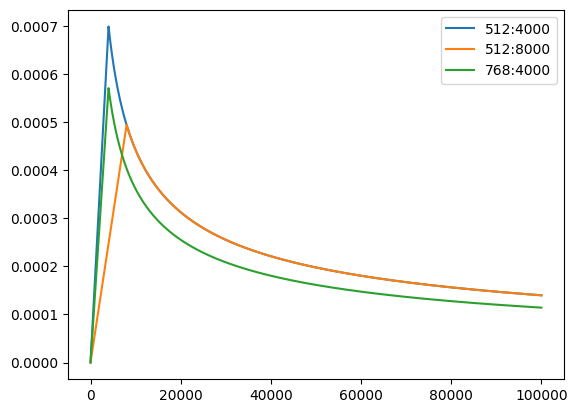

In [32]:
import matplotlib.pyplot as plt

schedulers = [transformer_scheduler(optim, conf["hidden_dim"], conf["warmup_steps"]),
transformer_scheduler(optim, conf["hidden_dim"], 8000),
transformer_scheduler(optim, 768, conf["warmup_steps"])
]
lrs = []
for scheduler in schedulers:
    actual_rl = []
    for i in range(1, 100000):
        actual_rl.append(scheduler.get_lr()[0])
        scheduler.step()
    lrs.append(actual_rl)
print(len(lrs), len(lrs[0]))
print(lrs[0][:10])

for i in range(len(lrs)):
    plt.plot(np.arange(1, 100000), lrs[i])

plt.legend(["512:4000", "512:8000", "768:4000"])
plt.show()


Model with higher hidden_dim gets lower lr using the proposed method. Also it is interesting that using more warmup steps lowers the maximum lr by quite a lot. The max lr is 7e-4 which can be seen as low, in the MiniCPM paper, they say that the best lr is 1e-2.

# Positional encoding

In [1]:
import torch
import torch.nn as nn

class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    def generate_encoding(self, seq_length):
        pe = torch.zeros((seq_length, self.hidden_dim), requires_grad=False)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim//2, 2):
                # incorrect implementation, 2*(i+1) is wrong
                pe[pos, 2*i] = torch.sin((pos/torch.pow(torch.tensor(10000), 2*i/self.hidden_dim)))
                pe[pos, (2*i+1)] = torch.cos((pos/torch.pow(torch.tensor(10000), 2*(i+1)/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)


torch.Size([128, 512])


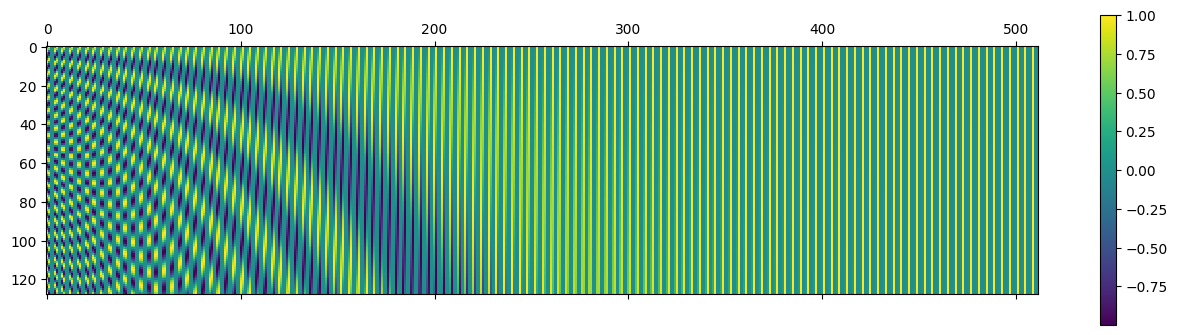

In [2]:
import matplotlib.pyplot as plt

conf = {"hidden_dim": 512, "vocabulary_size": 12000, "num_heads": 8, "intermediate_dim": 2048, "eps": 1e-06, "num_layers": 6, "dropout": 0.1,
            "label_smoothing": 0.1, "max_length": 128}
pe = positional_encoding(conf)
seq_length = 128
print(pe.encoding.shape)
plot = plt.matshow(pe.encoding)
plt.gcf().colorbar(plot)
plt.show()

In [3]:
pe.encoding[0][0:10], pe.encoding[1][0:10], 

(tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 tensor([0.8415, 0.5697, 0.0000, 0.0000, 0.8020, 0.6234, 0.0000, 0.0000, 0.7617,
         0.6709]))

torch.Size([128, 512])


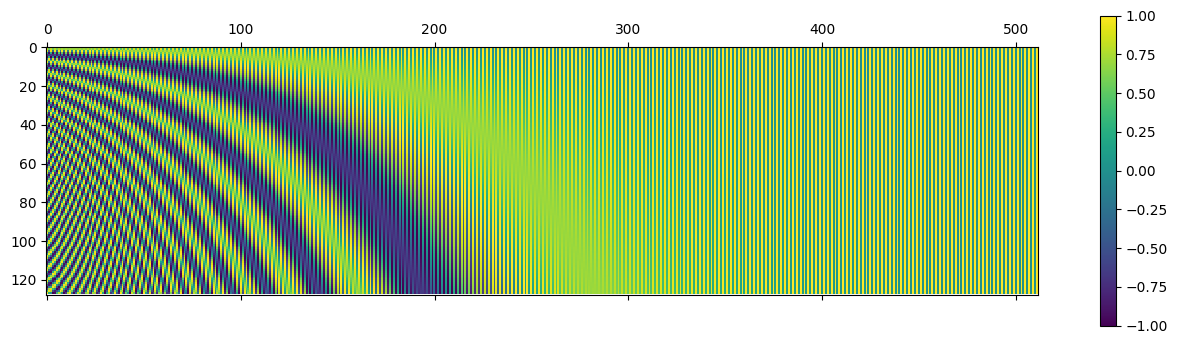

In [4]:
class PositionalEncoding_internet(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding_internet, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]


pe_internet = PositionalEncoding_internet(conf["hidden_dim"], conf["max_length"], "cpu")
print(pe_internet.encoding.shape)
plot = plt.matshow(pe_internet.encoding)
plt.gcf().colorbar(plot)
plt.show()

In [5]:
pe_internet.encoding[0][0:10], pe_internet.encoding[1][0:10], 

(tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]),
 tensor([0.8415, 0.5403, 0.8219, 0.5697, 0.8020, 0.5974, 0.7819, 0.6234, 0.7617,
         0.6479]))

In [6]:
pe.encoding == pe_internet.encoding

tensor([[ True,  True,  True,  ...,  True,  True, False],
        [ True, False, False,  ...,  True, False, False],
        [ True, False, False,  ...,  True, False, False],
        ...,
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])

In [7]:
import torch
import torch.nn as nn

class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    
    def generate_encoding(self, seq_length):
        pe = torch.zeros((seq_length, self.hidden_dim), requires_grad=False)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim, 2):
                # incorrect implementation, 2*(i+1) is wrong
                pe[pos, i] = torch.sin((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))
                pe[pos, i+1] = torch.cos((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)


torch.Size([128, 512])


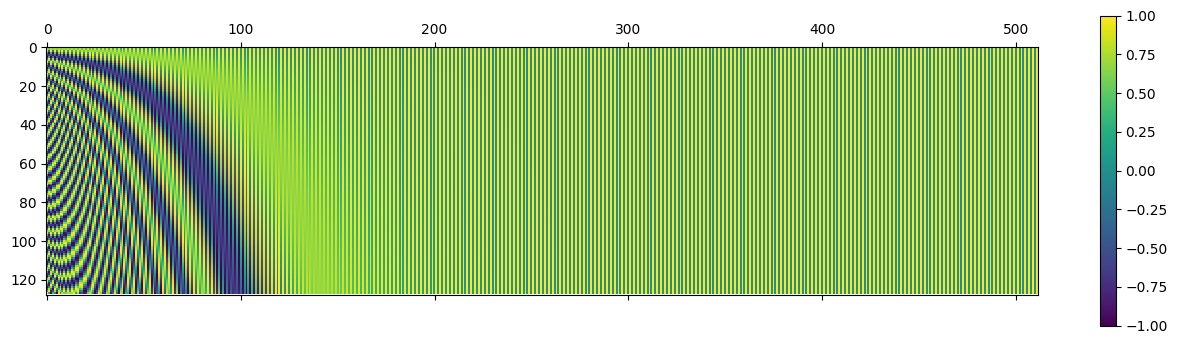

In [8]:
import matplotlib.pyplot as plt
conf["hidden_dim"] = 512
pe_2 = positional_encoding(conf)
print(pe_2.encoding.shape)
plot = plt.matshow(pe_2.encoding)
plt.gcf().colorbar(plot)
plt.show()

torch.Size([128, 512])


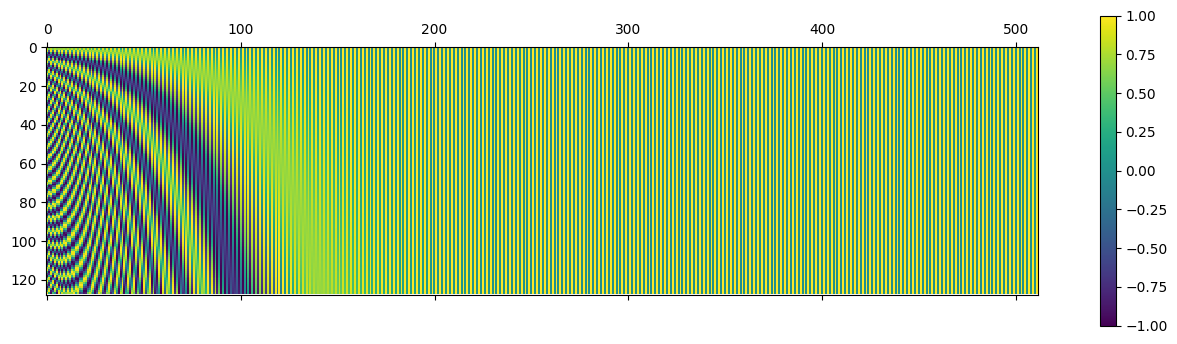

In [9]:
import math

class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    
    def generate_encoding(self, seq_length):
        pe = torch.zeros(seq_length, self.hidden_dim)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.hidden_dim)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)

pe_3 = positional_encoding(conf)
print(pe_3.encoding.shape)
plot = plt.matshow(pe_3.encoding)
plt.gcf().colorbar(plot)
plt.show()

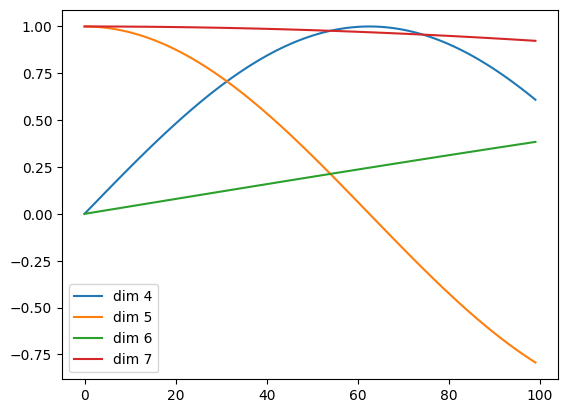

In [10]:
import numpy as np
conf["hidden_dim"]= 20
pe_3 = positional_encoding(conf)
plt.plot(np.arange(100), pe_3.encoding[:100, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

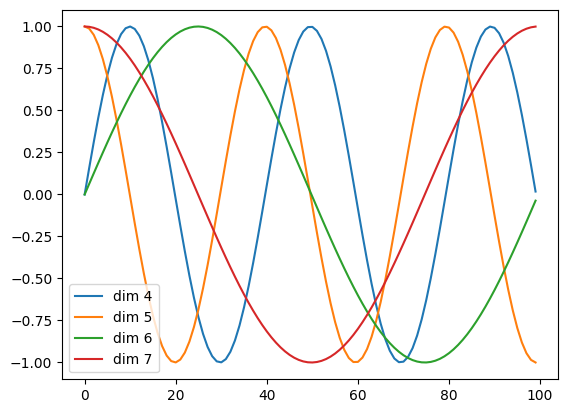

In [11]:
import numpy as np
conf["hidden_dim"]= 20
pe_internet = PositionalEncoding_internet(20, conf["max_length"], "cpu")
plt.plot(np.arange(100), pe_internet.encoding[:100, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

In [12]:
torch.arange(0, 512, step=2).float()

tensor([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
         24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
         48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
         72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
         96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
        120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
        144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
        192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
        216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
        240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
        264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
        288., 290., 292., 294., 296., 29

torch.Size([1, 128, 512])


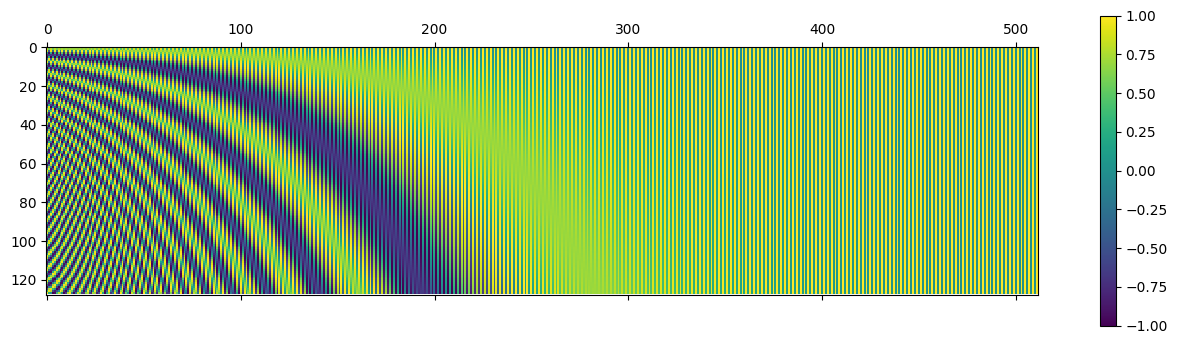

In [13]:
class PositionalEncoding_annotated(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding_annotated, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

pe_annotated = PositionalEncoding_annotated(512, 0.1, max_len=128)
print(pe_annotated.pe.shape)
plot = plt.matshow(pe_annotated.pe[0])
plt.gcf().colorbar(plot)
plt.show()

torch.Size([1, 128, 20])


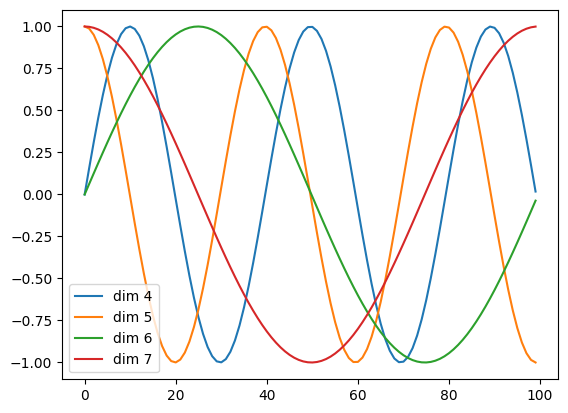

In [14]:
import numpy as np
pe_annotated = PositionalEncoding_annotated(20, 0.1, max_len=128)
print(pe_annotated.pe.shape)
plt.plot(np.arange(100), pe_annotated.pe[0, :100, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

In [21]:
import torch
import torch.nn as nn

class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    
    def generate_encoding(self, seq_length):
        pe = torch.zeros((seq_length, self.hidden_dim), requires_grad=False)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim, 2):
                # incorrect implementation, 2*(i+1) is wrong
                pe[pos, i] = torch.sin((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))
                pe[pos, i+1] = torch.cos((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)

class PositionalEncoding_internet(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding_internet, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]

class PositionalEncoding_annotated(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding_annotated, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)



conf["hidden_dim"] = 512
pe_2 = positional_encoding(conf)
pe_internet = PositionalEncoding_internet(conf["hidden_dim"], conf["max_length"], "cpu")
pe_annotated = PositionalEncoding_annotated(conf["hidden_dim"], 0.1, max_len=conf["max_length"])
print(pe_annotated.pe.shape, pe_internet.encoding.shape, pe_2.encoding.shape)

torch.Size([1, 128, 512]) torch.Size([128, 512]) torch.Size([128, 512])


In [28]:
# PE(pos, 2i) = sin(pos / 10000 ** (2*i / d_model))
# PE(pos, 2i+1) = cos(pos / 10000 ** (2*i / d_model))

pos = 10
i = 10
math.sin(pos / 10000 ** (2*i/512)), pe_annotated.pe[:, pos, 2*i], pe_internet.encoding[pos, 2*i], pe_2.encoding[pos, 2*i],  pe_2.encoding[pos, i]

(0.6404780171615887,
 tensor([0.6405]),
 tensor(0.6405),
 tensor(-0.9877),
 tensor(0.6405))

The problem is that my implementation doesn't work for 2*i but works for only i.

torch.Size([128, 512])


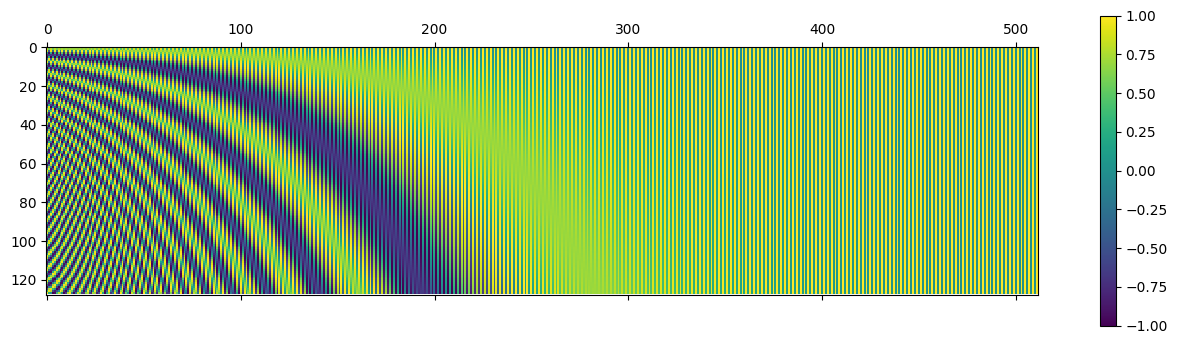

In [33]:
class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    
    def generate_encoding(self, seq_length):
        pe = torch.zeros((seq_length, self.hidden_dim), requires_grad=False)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim//2):
                # incorrect implementation, 2*(i+1) is wrong, we need step 1 if we use the 2*i format
                pe[pos, 2*i] = torch.sin((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))
                pe[pos, 2*i+1] = torch.cos((pos/torch.pow(torch.tensor(10000), 2*float(i)/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)

conf["hidden_dim"]= 512
pe_4 = positional_encoding(conf)
print(pe_4.encoding.shape)
plot = plt.matshow(pe_4.encoding)
plt.gcf().colorbar(plot)
plt.show()

We need to use step 1 if we use the 2*i format, as well as 2*i+1, the 1 is outside the 2 multiplication.

In [63]:
pe_4.encoding == pe_internet.encoding, torch.sum(pe_4.encoding - pe_internet.encoding), torch.sum(pe_4.encoding - pe_annotated.pe[0])

(tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True, False,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True, False,  True]]),
 tensor(5.2150e-05),
 tensor(-8.7068e-05))

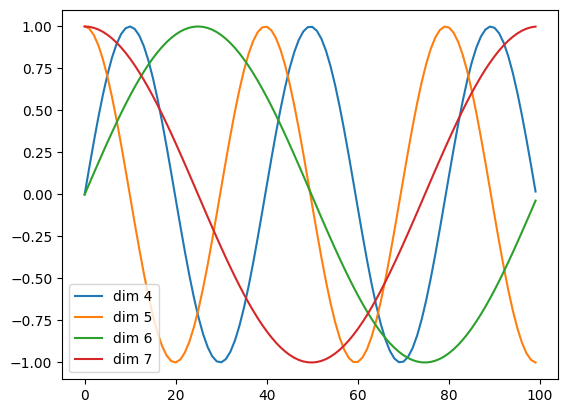

In [31]:
import numpy as np
conf["hidden_dim"]= 20
pe_4 = positional_encoding(conf)
plt.plot(np.arange(100), pe_4.encoding[:100, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

In [40]:
# PE(pos, 2i) = sin(pos / 10000 ** (2*i / d_model))
# PE(pos, 2i+1) = cos(pos / 10000 ** (2*i / d_model))

pos = 10
i = 10
print(math.sin(pos / 10000 ** (2*i/512)), pe_annotated.pe[:, pos, 2*i], pe_internet.encoding[pos, 2*i], pe_4.encoding[pos, 2*i])

pos = 10
i = 200
print(math.sin(pos / 10000 ** (2*i/512)), pe_annotated.pe[:, pos, 2*i], pe_internet.encoding[pos, 2*i], pe_4.encoding[pos, 2*i])

pos = 100
i = 200
print(math.sin(pos / 10000 ** (2*i/512)), pe_annotated.pe[:, pos, 2*i], pe_internet.encoding[pos, 2*i], pe_4.encoding[pos, 2*i])

0.6404780171615887 tensor([0.6405]) tensor(0.6405) tensor(0.6405)
0.007498871810771601 tensor([0.0075]) tensor(0.0075) tensor(0.0075)
0.07491915794147602 tensor([0.0749]) tensor(0.0749) tensor(0.0749)


In [43]:
pe_4.encoding[10] == pe_internet.encoding[10]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True, False, False, 

In [48]:
pe_4.encoding[10][:30], pe_internet.encoding[10][:30], torch.sum(pe_4.encoding[10][:30] - pe_internet.encoding[10][:30])

(tensor([-0.5440, -0.8391, -0.2200, -0.9755,  0.1188, -0.9929,  0.4331, -0.9014,
          0.6926, -0.7213,  0.8778, -0.4791,  0.9792, -0.2030,  0.9968,  0.0802,
          0.9376,  0.3476,  0.8139,  0.5811,  0.6405,  0.7680,  0.4336,  0.9011,
          0.2091,  0.9779, -0.0188,  0.9998, -0.2379,  0.9713]),
 tensor([-0.5440, -0.8391, -0.2200, -0.9755,  0.1188, -0.9929,  0.4331, -0.9014,
          0.6926, -0.7213,  0.8778, -0.4791,  0.9792, -0.2030,  0.9968,  0.0802,
          0.9376,  0.3476,  0.8139,  0.5811,  0.6405,  0.7680,  0.4336,  0.9011,
          0.2091,  0.9779, -0.0188,  0.9998, -0.2379,  0.9713]),
 tensor(-1.7881e-07))

In [59]:
torch.zeros((1, 12)).dtype

torch.float32

In [64]:
torch.sum(pe_internet.encoding - pe_annotated.pe[0])

tensor(-0.0001)

torch.Size([128, 512])


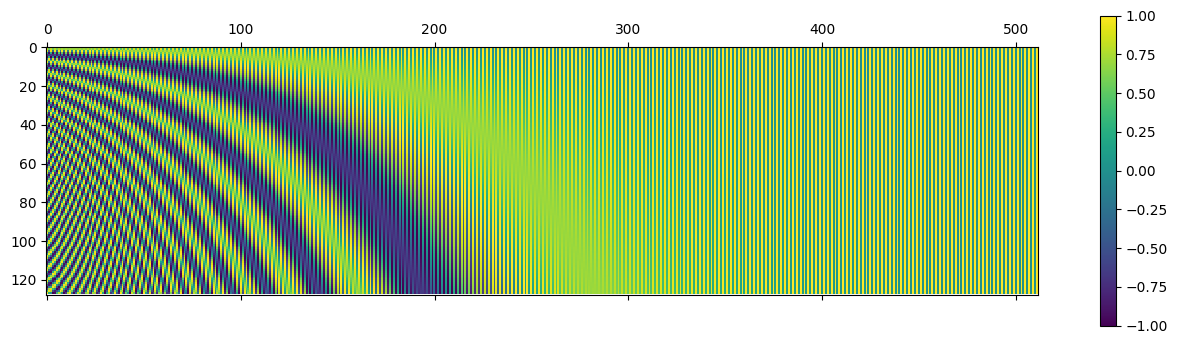

In [68]:
class positional_encoding(nn.Module):
    def __init__(self,conf) -> None:
        super(positional_encoding, self).__init__()

        self.hidden_dim = conf["hidden_dim"]
        self.dropout = conf["dropout"]
        self.max_seq_length = conf["max_length"]
        self.encoding = self.generate_encoding(self.max_seq_length)
    
    def generate_encoding(self, seq_length):
        pe = torch.zeros((seq_length, self.hidden_dim), requires_grad=False)

        # we just need to compute this once, then is just the same always
        for pos in range(seq_length):
            for i in range(0, self.hidden_dim//2):
                # incorrect implementation, 2*(i+1) is wrong, we need step 1 if we use the 2*i format
                pe[pos, 2*i] = torch.sin((pos/torch.pow(torch.tensor(10000), 2*i/self.hidden_dim)))
                pe[pos, 2*i+1] = torch.cos((pos/torch.pow(torch.tensor(10000), 2*i/self.hidden_dim)))

        return pe
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        """Forward of the positional embeddings class

        Args:
            x (torch.tensor): tensor containing the embeddings. [batch_size, seq_len, hidden_size]

        Returns:
            torch.tensor: [batch_size, seq_len, hidden_size]
        """
        # loop all the batch, no need, just sum and all ok
        # for i in range(x.shape[0]):
        # x -> [batch_size, seq_len, hidden_dim] and self.encoding -> [max_seq_len, hidden_dim]
        x += self.encoding[:x.shape[1]].to(x.device)
        
        return nn.functional.dropout(x)

conf["hidden_dim"]= 512
pe_4 = positional_encoding(conf)
print(pe_4.encoding.shape)
plot = plt.matshow(pe_4.encoding)
plt.gcf().colorbar(plot)
plt.show()

In [69]:
pe_4.encoding == pe_internet.encoding, torch.sum(pe_4.encoding - pe_internet.encoding), torch.sum(pe_4.encoding - pe_annotated.pe[0])

(tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True, False,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True, False,  True]]),
 tensor(5.2150e-05),
 tensor(-8.7068e-05))

In [67]:
10/512, float(10)/float(512)

(0.01953125, 0.01953125)

## Atention mask

In [10]:
def create_causal_mask_with_padding_mult(seq_len, padding_mask, device):
    """
    Creates a causal mask with padding taken into account.

    Args:
        seq_len (int): The length of the sequence.
        padding_mask (torch.Tensor): A tensor of shape (batch_size, seq_len) with 0 where padding is present and 1 otherwise.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 1, seq_len, seq_len) representing the causal mask with padding.
    """
    # Create a causal mask
    causal_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.float32, device=device))
    print(f"Shape of the first causal mask{causal_mask.shape}")
    # Combine with padding mask
    padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
    combined_mask = causal_mask.unsqueeze(0) * padding_mask
    print(f"Combined mask shape {combined_mask.shape}")
    combined_mask = (1-combined_mask) * torch.finfo(torch.float32).min

    return combined_mask


In [11]:
import torch

seq_len = 5
batch_size = 2
padding_mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 0, 0, 0]], dtype=torch.bool)

causal_mask_with_padding = create_causal_mask_with_padding_mult(seq_len, padding_mask, "cpu")
print(causal_mask_with_padding)
print(causal_mask_with_padding.shape)

Shape of the first causal masktorch.Size([5, 5])
Combined mask shape torch.Size([2, 1, 5, 5])
tensor([[[[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38]]],


        [[[-0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-0.0000e+00, -0.0000e+00, -3.4028e+38, -3.4028e+38, -3.4028e+38]]]])
torch.Size([2, 1, 5, 5])


In [15]:
a = torch.randn((1, 5, 5))
b = torch.randn((1, 1, 1, 5))
a, b

(tensor([[[ 1.0501e+00, -1.0521e+00, -1.2436e-01, -7.4274e-02, -9.5705e-01],
          [ 1.4716e-03,  1.5211e+00,  1.0098e+00, -2.9361e-01, -2.1959e-01],
          [ 6.6526e-01,  2.7449e-01, -4.8078e-01,  4.8763e-01, -2.5559e-01],
          [ 8.2073e-01,  1.3479e-01,  2.2420e+00,  1.5991e-01,  1.3723e+00],
          [-2.6834e-01,  2.2373e-01, -1.6018e+00,  9.4136e-01,  9.9710e-01]]]),
 tensor([[[[-0.5940,  2.6627, -1.5424,  0.8970,  0.3933]]]]))

In [17]:
a * b

tensor([[[[-6.2373e-01, -2.8014e+00,  1.9182e-01, -6.6623e-02, -3.7640e-01],
          [-8.7406e-04,  4.0501e+00, -1.5576e+00, -2.6336e-01, -8.6363e-02],
          [-3.9514e-01,  7.3089e-01,  7.4155e-01,  4.3740e-01, -1.0052e-01],
          [-4.8749e-01,  3.5890e-01, -3.4582e+00,  1.4343e-01,  5.3971e-01],
          [ 1.5938e-01,  5.9574e-01,  2.4707e+00,  8.4439e-01,  3.9215e-01]]]])

In [24]:
#   1 5 5
# 1 1 1 5
# In short, if a PyTorch operation supports broadcast, then its Tensor arguments can be automatically expanded to be of equal sizes 
# (without making copies of the data).

c = b.expand(1, 1, 5, 5)
c

tensor([[[[-0.5940,  2.6627, -1.5424,  0.8970,  0.3933],
          [-0.5940,  2.6627, -1.5424,  0.8970,  0.3933],
          [-0.5940,  2.6627, -1.5424,  0.8970,  0.3933],
          [-0.5940,  2.6627, -1.5424,  0.8970,  0.3933],
          [-0.5940,  2.6627, -1.5424,  0.8970,  0.3933]]]])

In [26]:
a * c, a * c == a * b

(tensor([[[[-6.2373e-01, -2.8014e+00,  1.9182e-01, -6.6623e-02, -3.7640e-01],
           [-8.7406e-04,  4.0501e+00, -1.5576e+00, -2.6336e-01, -8.6363e-02],
           [-3.9514e-01,  7.3089e-01,  7.4155e-01,  4.3740e-01, -1.0052e-01],
           [-4.8749e-01,  3.5890e-01, -3.4582e+00,  1.4343e-01,  5.3971e-01],
           [ 1.5938e-01,  5.9574e-01,  2.4707e+00,  8.4439e-01,  3.9215e-01]]]]),
 tensor([[[[True, True, True, True, True],
           [True, True, True, True, True],
           [True, True, True, True, True],
           [True, True, True, True, True],
           [True, True, True, True, True]]]]))

In [30]:
a[0][0] * c [0][0][0], a[0][0], c [0][0][0], 

(tensor([-0.6237, -2.8014,  0.1918, -0.0666, -0.3764]),
 tensor([ 1.0501, -1.0521, -0.1244, -0.0743, -0.9570]),
 tensor([-0.5940,  2.6627, -1.5424,  0.8970,  0.3933]))

Torch broadcasting is really important we need to take into account that the missing dims are filled copying the tensor.

## Grad Norm

In [40]:
import torch
a = torch.randn((1, 12, 512))
b = a.clone()
a.requires_grad_(True)
b.requires_grad_(True)
loss = 1/2 * torch.sum(a * a + b * b)
loss.backward()

torch.nn.utils.clip_grad_norm_(a, max_norm=5.0, norm_type=2)
print(a.grad)
print(b.grad)
print(a.grad == b.grad)

tensor([[[-0.0141,  0.0483, -0.1151,  ..., -0.0797,  0.0870, -0.0713],
         [-0.0203,  0.0189,  0.0142,  ...,  0.0815,  0.2144,  0.0434],
         [ 0.0205, -0.0607, -0.0705,  ...,  0.0583,  0.1313, -0.0176],
         ...,
         [ 0.0499, -0.0548, -0.0253,  ...,  0.0289, -0.1092,  0.0625],
         [-0.0578,  0.1110,  0.0497,  ...,  0.0568, -0.0925,  0.0779],
         [-0.0173, -0.0404, -0.0428,  ..., -0.0126,  0.0047,  0.0707]]])
tensor([[[-0.2210,  0.7580, -1.8064,  ..., -1.2510,  1.3646, -1.1193],
         [-0.3182,  0.2960,  0.2227,  ...,  1.2790,  3.3633,  0.6811],
         [ 0.3224, -0.9525, -1.1063,  ...,  0.9152,  2.0598, -0.2766],
         ...,
         [ 0.7836, -0.8590, -0.3973,  ...,  0.4534, -1.7136,  0.9802],
         [-0.9064,  1.7409,  0.7796,  ...,  0.8913, -1.4509,  1.2215],
         [-0.2718, -0.6337, -0.6711,  ..., -0.1983,  0.0735,  1.1088]]])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]

In [41]:
torch.linalg.vector_norm(a.grad, 2.0), b.grad.norm(), a.norm()

(tensor(5.0000),
 tensor(78.4413),
 tensor(78.4413, grad_fn=<LinalgVectorNormBackward0>))

In [32]:
v = torch.rand(5) * 1000
v_1 = v.clone()
v.requires_grad_(True)
v_1.requires_grad_(True)

loss = 1/2 * torch.sum(v_1 * v_1 + v * v)
# Here grads of loss w.r.t v and v_1 should be v and v_1 respectively
loss.backward()

# Clip grads of v_1
torch.nn.utils.clip_grad_norm_(v_1, max_norm=1.0, norm_type=2)

print(v.grad)
print(v_1.grad)
print(v.grad / torch.norm(v.grad, p=2))

tensor([196.9137, 571.8171, 232.0943, 990.4624, 238.5350])
tensor([0.1631, 0.4736, 0.1922, 0.8204, 0.1976])
tensor([0.1631, 0.4736, 0.1922, 0.8204, 0.1976])


In [44]:
v = torch.randn(12)
v_1 = v.clone()
v.requires_grad_(True)
v_1.requires_grad_(True)

loss = 1/2 * torch.sum(v_1 * v_1 + v * v)
# Here grads of loss w.r.t v and v_1 should be v and v_1 respectively
loss.backward()

# Clip grads of v_1
torch.nn.utils.clip_grad_value_(v_1, clip_value=2.0)

print(v.grad)
print(torch.norm(v.grad, p=2))
print(v_1.grad)
print(torch.norm(v_1.grad, p=2))
print(v.grad / torch.norm(v.grad, p=2))

tensor([ 0.5971,  1.3447, -0.0090, -0.7381, -0.0986,  0.6170, -2.1201, -0.5373,
        -1.2143,  2.0257,  0.9233,  0.8036])
tensor(3.8678)
tensor([ 0.5971,  1.3447, -0.0090, -0.7381, -0.0986,  0.6170, -2.0000, -0.5373,
        -1.2143,  2.0000,  0.9233,  0.8036])
tensor(3.7897)
tensor([ 0.1544,  0.3477, -0.0023, -0.1908, -0.0255,  0.1595, -0.5481, -0.1389,
        -0.3140,  0.5237,  0.2387,  0.2078])


# Hydra

In [ ]:
import omegaconf
path = "config.yml"
conf = omegaconf.OmegaConf.load(path)


In [2]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"".join(conf.train.tokenizer_path), bos_token="<bos>", eos_token="<eos>",
                                   pad_token="<pad>", unk_token="<unk>")
tokenizer

PreTrainedTokenizerFast(name_or_path='', vocab_size=37000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [22]:
print(tokenizer.eos_token)
print(tokenizer.pad_token)
print(tokenizer.unk_token)
print(tokenizer.eos_token_id)
print(tokenizer.pad_token_id)
print(tokenizer.unk_token_id)
print(tokenizer.build_inputs_with_special_tokens)
# tokenizer.pad_token = "[PAD]"
# tokenizer.eos_token = "[PAD]"

<eos>
<pad>
<unk>
2
3
0
<bound method PreTrainedTokenizerBase.build_inputs_with_special_tokens of PreTrainedTokenizerFast(name_or_path='', vocab_size=37000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}>


In [21]:
text = "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."
text = "<bos>" + text + "<eos>"
tokenizer(text,  max_length=conf.train.max_length, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True, return_token_type_ids=False)

{'input_ids': tensor([[    1,  3725, 10345,    13,   135,  5275,  4353,  2206,  3145,    13,
           137,   383,  3654,    10,    72,  3594,    73,  2030, 18195,    10,
           587, 15627,   151,  6437,  1743,    13,  6721,   137,   244,   103,
            60,  2322,   148, 31534,  2833,  2501,   281,    60, 11082,   148,
         17296,  1404,  2088,   169,   814,   285,   352,    84,  9898,  5680,
           728,    15,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

If the sequence gets truncated, then the eos token dissapears so maybe it is better to add them after tokenization. Or just check if the length if the max_len, if true then substitute the last token by eos, but if there is padding?

In [3]:
from tokenizers.processors import TemplateProcessing

bos = tokenizer.bos_token
eos = tokenizer.eos_token
tokenizer._tokenizer.post_processor =TemplateProcessing(
    single=f"{bos}:0 $A:0 {eos}:0",
    special_tokens=[
        (f"{bos}", tokenizer.bos_token_id), 
        (f"{eos}", tokenizer.eos_token_id)
    ],
)

text = "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."
tokenizer(text,  max_length=conf.train.max_length, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True, return_token_type_ids=False)

{'input_ids': tensor([[    1,  3725, 10345,    13,   135,  5275,  4353,  2206,  3145,    13,
           137,   383,  3654,    10,    72,  3594,    73,  2030, 18195,    10,
           587, 15627,   151,  6437,  1743,    13,  6721,   137,   244,   103,
            60,  2322,   148, 31534,  2833,  2501,   281,    60, 11082,   148,
         17296,  1404,  2088,   169,   814,   285,   352,    84,  9898,  5680,
           728,    15,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

In [4]:
text = "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."
tokenizer(text,  max_length=16, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True, return_token_type_ids=False)

{'input_ids': tensor([[    1,  3725, 10345,    13,   135,  5275,  4353,  2206,  3145,    13,
           137,   383,  3654,    10,    72,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
import torch
from torch.utils.data import DataLoader
import datasets

In [6]:
data = datasets.load_dataset("bentrevett/multi30k", split="train")
data

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
})

In [12]:
from torch.utils.data import default_collate

def collate_fn(batch, tokenizer, conf):
    batch = default_collate(batch)
    # for sample in batch:
    #     sample["en"] = tokenizer.bos_token + sample["en"] + tokenizer.eos_token
    #     sample["de"] = tokenizer.bos_token + sample["de"] + tokenizer.eos_token

    # we need to add special tokens
    inputs = tokenizer(batch["en"],  max_length=conf.train.max_length, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True)
    outputs = tokenizer(batch["de"],  max_length=conf.train.max_length, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True)

    return {"en": inputs, "de": outputs}

train_loader = DataLoader(data, batch_size=2, collate_fn=lambda batch: collate_fn(batch, tokenizer, conf), )


In [16]:
for batch in train_loader:
    print(batch)
    print("*"*10)
    print(tokenizer.convert_ids_to_tokens(batch['de']['input_ids'][0], skip_special_tokens=False))
    print(tokenizer.convert_ids_to_tokens(batch['de']['input_ids'][1], skip_special_tokens=False))
    break

{'en': {'input_ids': tensor([[    1,   217,   273,    13,  5008,  3650,   192,   479,   581,  1788,
          5743,    15,     2,     3],
        [    1,  1032,   179,   103,  1703,  1578,   192,  5282,    60,  3494,
         16171,  8936,    15,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, 'de': {'input_ids': tensor([[    1,   214,   544,  1392,   306,   708,   168,   743,   103,   145,
           839, 16289, 12140,    15,     2],
        [    1,   699,   306,   139,  4161,  8649,   107, 27342, 31089,    15,
             2,     3,     3,     3,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 

In [17]:
from torch.utils.data import default_collate

def collate_fn(batch, tokenizer, conf):
    batch = default_collate(batch)
    # for sample in batch:
    #     sample["en"] = tokenizer.bos_token + sample["en"] + tokenizer.eos_token
    #     sample["de"] = tokenizer.bos_token + sample["de"] + tokenizer.eos_token

    # we need to add special tokens
    inputs = tokenizer(batch["en"],  max_length=8, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True)
    outputs = tokenizer(batch["de"],  max_length=8, padding="longest", truncation=True, return_tensors="pt",
                       add_special_tokens=True)

    return {"en": inputs, "de": outputs}

train_loader = DataLoader(data, batch_size=2, collate_fn=lambda batch: collate_fn(batch, tokenizer, conf), )

for batch in train_loader:
    print(batch)
    print("*"*10)
    print(tokenizer.convert_ids_to_tokens(batch['de']['input_ids'][0], skip_special_tokens=False))
    print(tokenizer.convert_ids_to_tokens(batch['de']['input_ids'][1], skip_special_tokens=False))
    break

{'en': {'input_ids': tensor([[   1,  217,  273,   13, 5008, 3650,  192,    2],
        [   1, 1032,  179,  103, 1703, 1578,  192,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}, 'de': {'input_ids': tensor([[   1,  214,  544, 1392,  306,  708,  168,    2],
        [   1,  699,  306,  139, 4161, 8649,  107,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])}}
**********
['<bos>', 'Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', '<eos>']
['<bos>', 'Mehrere', 'Männer', 'mit', 'Schutzhelmen', 'bedienen', 'ein', '<eos>']


# Init weights

In [1]:
import omegaconf
path = r"CONFIG-PATH"
conf = omegaconf.OmegaConf.load(path)
conf

{'transformer': {'hidden_dim': 512, 'num_heads': 8, 'intermediate_dim': 2048, 'eps': 1e-06, 'num_layers': 6, 'dropout': 0.1, 'label_smoothing': 0.1}, 'train': {'warmup_steps': 4000, 'max_length': 128, 'device': 'cpu', 'train_batch': 4, 'eval_batch': 4, 'steps': 10, 'val_steps': 4, 'log_steps': 4, 'save_steps': 4, 'use_bitsandbytes': False, 'save_path': 'weights/', 'dataset_name': 'bentrevett/multi30k'}, 'inference': {'checkpoint': 'CHECKPOINT-PATH'}, 'tokenizer': {'tokenizer_path': 'data\\tokenizer.json', 'vocabulary_size': 37000, 'special_tokens': ['<unk>', '<bos>', '<eos>', '<pad>'], 'unk_token': '<unk>', 'save_path': 'data'}}

In [2]:
import sys

sys.path.insert(0, r"PROJECT-PATH") 

from transformer_implementation import transformer


In [3]:
model = transformer(conf)
model

transformer(
  (encoder): encoder(
    (layers): ModuleList(
      (0-5): 6 x encoder_block(
        (msha): multi_head_self_attention(
          (q): Linear(in_features=512, out_features=512, bias=False)
          (k): Linear(in_features=512, out_features=512, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (output_projection): Linear(in_features=512, out_features=512, bias=False)
        )
        (ff): feed_forward(
          (input_projection): Linear(in_features=512, out_features=2048, bias=True)
          (output_projection): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): ReLU(inplace=True)
        )
        (layernorm1): layer_norm()
        (layernorm2): layer_norm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): decoder(
    (layers): ModuleList(
      (0-5): 6 x decoder_block(
        (msha): multi_head_self_attention(
 

In [32]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)



encoder.layers.0.msha.q.weight tensor([[ 0.0318,  0.0131,  0.0214,  ...,  0.0009,  0.0328,  0.0004],
        [-0.0075,  0.0155, -0.0302,  ...,  0.0292, -0.0081,  0.0226],
        [ 0.0009, -0.0118, -0.0122,  ..., -0.0337,  0.0281,  0.0275],
        ...,
        [-0.0238, -0.0122,  0.0425,  ...,  0.0129,  0.0060, -0.0115],
        [-0.0208, -0.0414,  0.0219,  ...,  0.0329,  0.0360, -0.0325],
        [ 0.0315, -0.0441, -0.0378,  ...,  0.0094,  0.0261,  0.0093]])
encoder.layers.0.msha.k.weight tensor([[ 0.0370,  0.0060,  0.0248,  ..., -0.0424, -0.0074, -0.0294],
        [-0.0432,  0.0348,  0.0156,  ...,  0.0367,  0.0261, -0.0111],
        [-0.0349, -0.0078, -0.0393,  ..., -0.0315,  0.0372,  0.0261],
        ...,
        [-0.0014, -0.0397,  0.0212,  ...,  0.0385,  0.0105,  0.0425],
        [-0.0140, -0.0039,  0.0336,  ...,  0.0049,  0.0426,  0.0271],
        [-0.0050, -0.0324, -0.0206,  ...,  0.0313, -0.0207, -0.0437]])
encoder.layers.0.msha.v.weight tensor([[ 0.0410, -0.0321, -0.0275,  ..

In [7]:
import torch.nn.init as init
import torch.nn as nn

def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        # 512 is the hidden_dim
        # init.normal_(m.weight.data, mean=0, std=torch.sqrt(2/5*512))
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)
model.apply(weights_init)

transformer(
  (encoder): encoder(
    (layers): ModuleList(
      (0-5): 6 x encoder_block(
        (msha): multi_head_self_attention(
          (q): Linear(in_features=512, out_features=512, bias=False)
          (k): Linear(in_features=512, out_features=512, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (output_projection): Linear(in_features=512, out_features=512, bias=False)
        )
        (ff): feed_forward(
          (input_projection): Linear(in_features=512, out_features=2048, bias=True)
          (output_projection): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): ReLU(inplace=True)
        )
        (layernorm1): layer_norm()
        (layernorm2): layer_norm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): decoder(
    (layers): ModuleList(
      (0-5): 6 x decoder_block(
        (msha): multi_head_self_attention(
 

In [23]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)



encoder.layers.0.msha.q.weight
encoder.layers.0.msha.k.weight
encoder.layers.0.msha.v.weight
encoder.layers.0.msha.output_projection.weight
encoder.layers.0.ff.input_projection.weight
encoder.layers.0.ff.input_projection.bias
encoder.layers.0.ff.output_projection.weight
encoder.layers.0.ff.output_projection.bias
encoder.layers.0.layernorm1.gamma
encoder.layers.0.layernorm1.beta
encoder.layers.0.layernorm2.gamma
encoder.layers.0.layernorm2.beta
encoder.layers.1.msha.q.weight
encoder.layers.1.msha.k.weight
encoder.layers.1.msha.v.weight
encoder.layers.1.msha.output_projection.weight
encoder.layers.1.ff.input_projection.weight
encoder.layers.1.ff.input_projection.bias
encoder.layers.1.ff.output_projection.weight
encoder.layers.1.ff.output_projection.bias
encoder.layers.1.layernorm1.gamma
encoder.layers.1.layernorm1.beta
encoder.layers.1.layernorm2.gamma
encoder.layers.1.layernorm2.beta
encoder.layers.2.msha.q.weight
encoder.layers.2.msha.k.weight
encoder.layers.2.msha.v.weight
encoder.lay

In [24]:
text = "encoder.layers.2.ff.output_projection.bias"
text.split(".")

['encoder', 'layers', '2', 'ff', 'output_projection', 'bias']

In [8]:
import torch
import math

def apply_weights_init(model, conf):
    std = math.sqrt(2/5*conf.transformer.hidden_dim)
    for name, param in model.named_parameters():
        if param.requires_grad:
            if 'gamma' in name.split('.') or 'beta' in name.split('.') or 'lm_head' in name.split('.'):
                continue
            if 'bias' in name.split('.'):
                nn.init.constant_(param.data, 0.0)
            elif 'output_projection' in name.split('.'):
                init.normal_(param.data, mean=0, std=std/math.sqrt(2*conf.transformer.num_layers))
            else:
                init.normal_(param.data, mean=0, std=std)
    # return model
apply_weights_init(model, conf)

In [29]:
model2 == model

True

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)



encoder.layers.0.msha.q.weight tensor([[  9.6717,   1.5165,  10.6365,  ...,  34.4361,   4.0302, -21.2087],
        [  5.4107,  -8.8120,   6.7790,  ...,  -1.1434,  -5.9951,   7.0695],
        [ -0.4137, -33.2633,   6.4574,  ...,   7.9046,  -8.4010,   8.0828],
        ...,
        [-15.2115, -16.0250,  -2.8856,  ...,  19.4812,  20.4852,   6.8060],
        [  1.5187,  28.1552,  -9.1866,  ...,  29.5409, -20.6487,  -3.8609],
        [ 11.9430,  -7.7020,   3.7234,  ...,  26.4998, -21.0232,   2.0380]])
encoder.layers.0.msha.k.weight tensor([[ -9.8731, -15.5707,  -5.3695,  ..., -18.4050,  10.8874, -25.8077],
        [ -2.3416,  -3.0768, -11.9929,  ..., -13.0363,  -9.7762,  22.0203],
        [  5.9272,  20.0848,  24.9595,  ...,  12.7774,   4.0592,  -6.0374],
        ...,
        [ 10.6049,  -9.1884,   1.4748,  ...,  16.8379, -23.4905,   0.3166],
        [-21.5786,  16.7947, -10.9881,  ...,   1.1027,   8.7340,  24.7211],
        [ -6.0079,   9.2707,   9.0853,  ...,   8.6614,   3.2917,   2.8339]]

In [5]:
print(model.state_dict().keys())

odict_keys(['encoder.layers.0.msha.q.weight', 'encoder.layers.0.msha.k.weight', 'encoder.layers.0.msha.v.weight', 'encoder.layers.0.msha.output_projection.weight', 'encoder.layers.0.ff.input_projection.weight', 'encoder.layers.0.ff.input_projection.bias', 'encoder.layers.0.ff.output_projection.weight', 'encoder.layers.0.ff.output_projection.bias', 'encoder.layers.0.layernorm1.gamma', 'encoder.layers.0.layernorm1.beta', 'encoder.layers.0.layernorm2.gamma', 'encoder.layers.0.layernorm2.beta', 'encoder.layers.1.msha.q.weight', 'encoder.layers.1.msha.k.weight', 'encoder.layers.1.msha.v.weight', 'encoder.layers.1.msha.output_projection.weight', 'encoder.layers.1.ff.input_projection.weight', 'encoder.layers.1.ff.input_projection.bias', 'encoder.layers.1.ff.output_projection.weight', 'encoder.layers.1.ff.output_projection.bias', 'encoder.layers.1.layernorm1.gamma', 'encoder.layers.1.layernorm1.beta', 'encoder.layers.1.layernorm2.gamma', 'encoder.layers.1.layernorm2.beta', 'encoder.layers.2.ms

In [18]:
torch.sum(model.lm_head.weight - model.embeddings.weights.weight), model.lm_head.weight == model.embeddings.weights.weight

(tensor(0., grad_fn=<SumBackward0>),
 tensor([[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]))

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

56754176

In [22]:
import numpy as np

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

56754176

In [23]:
torch.save(model.state_dict(), "model.safetensors")


In [24]:
net_weights = torch.load(r'model.safetensors')
net_weights

OrderedDict([('encoder.layers.0.msha.q.weight',
              tensor([[ -5.3662,  -2.4894,  13.4575,  ...,  14.9241,  -2.1344,  -7.6524],
                      [-17.6040,  13.4496,   5.4519,  ..., -37.6575, -19.0753, -22.9611],
                      [ 15.9009,  17.3507,  39.5073,  ...,  10.3751, -22.0404,   3.3568],
                      ...,
                      [ 13.2588,   7.3978,  25.3185,  ...,  -3.1869,   0.7964,  31.3996],
                      [-16.7277, -22.1362,  10.5649,  ...,   9.4514, -18.3651,  -7.3217],
                      [ 17.8540,  24.4207,  24.8002,  ...,  -2.6285,  -5.1104,   7.3426]])),
             ('encoder.layers.0.msha.k.weight',
              tensor([[ -0.7257,  -0.5132,  23.6234,  ...,   4.4615,  -2.4962,  -1.2803],
                      [ 21.8128, -14.3337,  28.1453,  ..., -20.7623,   0.9452,  14.7272],
                      [  2.9843,   4.2952, -12.5244,  ..., -13.3287, -22.1231,   3.8594],
                      ...,
                      [-12.8257,  18.

In [34]:
# the lm_head is the last element so we can just pop it
dict_save = model.state_dict().pop('lm_head.weight')
print(model.state_dict().keys())

odict_keys(['encoder.layers.0.msha.q.weight', 'encoder.layers.0.msha.k.weight', 'encoder.layers.0.msha.v.weight', 'encoder.layers.0.msha.output_projection.weight', 'encoder.layers.0.ff.input_projection.weight', 'encoder.layers.0.ff.input_projection.bias', 'encoder.layers.0.ff.output_projection.weight', 'encoder.layers.0.ff.output_projection.bias', 'encoder.layers.0.layernorm1.gamma', 'encoder.layers.0.layernorm1.beta', 'encoder.layers.0.layernorm2.gamma', 'encoder.layers.0.layernorm2.beta', 'encoder.layers.1.msha.q.weight', 'encoder.layers.1.msha.k.weight', 'encoder.layers.1.msha.v.weight', 'encoder.layers.1.msha.output_projection.weight', 'encoder.layers.1.ff.input_projection.weight', 'encoder.layers.1.ff.input_projection.bias', 'encoder.layers.1.ff.output_projection.weight', 'encoder.layers.1.ff.output_projection.bias', 'encoder.layers.1.layernorm1.gamma', 'encoder.layers.1.layernorm1.beta', 'encoder.layers.1.layernorm2.gamma', 'encoder.layers.1.layernorm2.beta', 'encoder.layers.2.ms

In [37]:
sd = model.state_dict()

del sd['lm_head.weight']
print(sd.keys())

odict_keys(['encoder.layers.0.msha.q.weight', 'encoder.layers.0.msha.k.weight', 'encoder.layers.0.msha.v.weight', 'encoder.layers.0.msha.output_projection.weight', 'encoder.layers.0.ff.input_projection.weight', 'encoder.layers.0.ff.input_projection.bias', 'encoder.layers.0.ff.output_projection.weight', 'encoder.layers.0.ff.output_projection.bias', 'encoder.layers.0.layernorm1.gamma', 'encoder.layers.0.layernorm1.beta', 'encoder.layers.0.layernorm2.gamma', 'encoder.layers.0.layernorm2.beta', 'encoder.layers.1.msha.q.weight', 'encoder.layers.1.msha.k.weight', 'encoder.layers.1.msha.v.weight', 'encoder.layers.1.msha.output_projection.weight', 'encoder.layers.1.ff.input_projection.weight', 'encoder.layers.1.ff.input_projection.bias', 'encoder.layers.1.ff.output_projection.weight', 'encoder.layers.1.ff.output_projection.bias', 'encoder.layers.1.layernorm1.gamma', 'encoder.layers.1.layernorm1.beta', 'encoder.layers.1.layernorm2.gamma', 'encoder.layers.1.layernorm2.beta', 'encoder.layers.2.ms

In [9]:
# torch.save(sd, "model.safetensors")
net_weights = torch.load(r'model.safetensors')
net_weights

OrderedDict([('encoder.layers.0.msha.q.weight',
              tensor([[ -5.3662,  -2.4894,  13.4575,  ...,  14.9241,  -2.1344,  -7.6524],
                      [-17.6040,  13.4496,   5.4519,  ..., -37.6575, -19.0753, -22.9611],
                      [ 15.9009,  17.3507,  39.5073,  ...,  10.3751, -22.0404,   3.3568],
                      ...,
                      [ 13.2588,   7.3978,  25.3185,  ...,  -3.1869,   0.7964,  31.3996],
                      [-16.7277, -22.1362,  10.5649,  ...,   9.4514, -18.3651,  -7.3217],
                      [ 17.8540,  24.4207,  24.8002,  ...,  -2.6285,  -5.1104,   7.3426]])),
             ('encoder.layers.0.msha.k.weight',
              tensor([[ -0.7257,  -0.5132,  23.6234,  ...,   4.4615,  -2.4962,  -1.2803],
                      [ 21.8128, -14.3337,  28.1453,  ..., -20.7623,   0.9452,  14.7272],
                      [  2.9843,   4.2952, -12.5244,  ..., -13.3287, -22.1231,   3.8594],
                      ...,
                      [-12.8257,  18.

In [10]:
model.load_state_dict(net_weights)

<All keys matched successfully>

In [12]:
model.set_tied_embeddings()
model

transformer(
  (encoder): encoder(
    (layers): ModuleList(
      (0-5): 6 x encoder_block(
        (msha): multi_head_self_attention(
          (q): Linear(in_features=512, out_features=512, bias=False)
          (k): Linear(in_features=512, out_features=512, bias=False)
          (v): Linear(in_features=512, out_features=512, bias=False)
          (output_projection): Linear(in_features=512, out_features=512, bias=False)
        )
        (ff): feed_forward(
          (input_projection): Linear(in_features=512, out_features=2048, bias=True)
          (output_projection): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): ReLU(inplace=True)
        )
        (layernorm1): layer_norm()
        (layernorm2): layer_norm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): decoder(
    (layers): ModuleList(
      (0-5): 6 x decoder_block(
        (msha): multi_head_self_attention(
 

In [13]:
model.lm_head.weight == model.embeddings.weights.weight

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

56754176

# Analysis of the activations and gradients

In [1]:
import omegaconf
path = r"CONFIG-FILE"
conf = omegaconf.OmegaConf.load(path)

In [2]:
import sys

sys.path.insert(0, r"DIRECTORY-PATH") 

from transformer_implementation import transformer
import matplotlib.pyplot as plt # for making figures
%matplotlib inline



In [3]:
from util.prepara_data import prepare_data
from util.prepare_model import prepare_training, get_update_ratio

model, tokenizer, optim, scheduler = prepare_training(conf)
train_loader, val_loader = prepare_data(tokenizer, conf)


Model loaded
Optim loaded
Dataset loaded!
1813
127


In [9]:
text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
print(inputs)
inputs = {k: v.to(conf.train.device) for k, v in inputs.items()}
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
target_tokens = {k: v.to(conf.train.device) for k, v in target_tokens.items()}
print(target_tokens["input_ids"][0][0])


{'input_ids': tensor([[    1,   566,   189,   213,    13,   189,   103,  2239,   235,  5664,
          5352,  2206,    60,  4912,  8874,    84, 18742,   155,  5068,   347,
           151,   137,  1855, 34659,   121,   189,   180,  3385,  2206,   151,
           624,   355,   155,  8573,   565,  2297,  7098,   276,   148,   137,
          1855, 34659,    15,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor(1)


In [10]:
import torch
    
model.train()
logits, loss, last_hidden_states, attentions_array, activations_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True, output_activation_state=True)


In [15]:
print(activations_array[0], activations_array[0].shape)
print(activations_array[0][0].mean(), activations_array[0][0].std())

tensor([[[0.0000, 0.5763, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1296, 0.2468, 0.1827,  ..., 0.0000, 0.4445, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.2743,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1154,  ..., 0.9259, 1.2526, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2333, 0.0000, 0.0000]]],
       grad_fn=<AsStridedBackward0>) torch.Size([1, 36, 2048])
tensor(0.2461, grad_fn=<MeanBackward0>) tensor(0.3667, grad_fn=<StdBackward0>)


In [23]:
# we need to run backward to have the gradients
print(loss)
loss.backward()

tensor(10.8766, grad_fn=<AddBackward0>)


layer 0 (      ReLU): mean +0.25, std 0.37, saturated: 51.06%
layer 1 (      ReLU): mean +0.26, std 0.37, saturated: 49.15%
layer 2 (      ReLU): mean +0.26, std 0.37, saturated: 49.54%
layer 3 (      ReLU): mean +0.26, std 0.37, saturated: 48.84%
layer 4 (      ReLU): mean +0.25, std 0.37, saturated: 50.06%
layer 5 (      ReLU): mean +0.25, std 0.37, saturated: 50.13%


Text(0.5, 1.0, 'activation distribution')

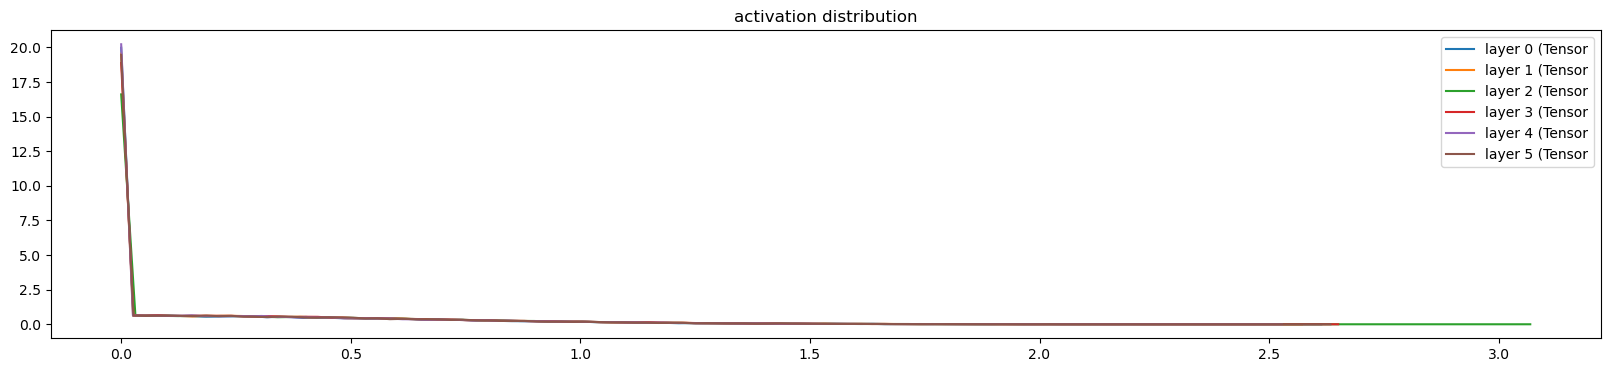

In [20]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(activations_array): # note: exclude the output layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "ReLU", layer.mean(),layer.std(), (layer.abs() == 0.00).float().mean()*100))
    hy, hx = torch.histogram(layer, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

We can see that half of the values are negative and get changed to 0.0, but the mean is still positive so the gradients are flowing correctly I think. As almost half of the samples activate this neuron, then this is not a dyed relu, the gradient is flowing normally.

weight (512, 512) | mean +0.000001 | std 3.586517e-03 | grad:data ratio 4.439251e-01
weight (512, 512) | mean +0.000003 | std 2.899502e-03 | grad:data ratio 3.595429e-01
weight (512, 512) | mean +0.000001 | std 2.932721e-03 | grad:data ratio 3.634063e-01
weight (37000, 512) | mean -0.000000 | std 1.036538e-03 | grad:data ratio 3.707562e-02


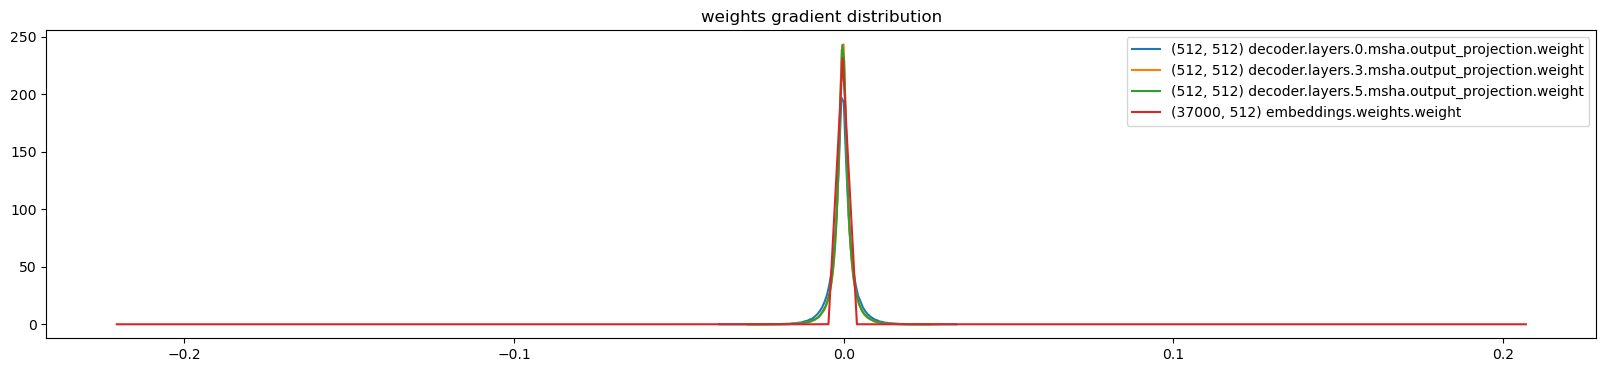

In [39]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.msha.output_projection.weight",  "decoder.layers.3.msha.output_projection.weight",  "decoder.layers.0.msha.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{tuple(param.shape)} {name}')
plt.legend(legends)
plt.title('weights gradient distribution');

weight (2048, 512) | mean +0.000000 | std 6.253964e-04 | grad:data ratio 2.239360e-02
weight (512, 2048) | mean -0.000003 | std 2.222534e-03 | grad:data ratio 2.754673e-01
weight (2048, 512) | mean +0.000000 | std 6.285469e-04 | grad:data ratio 2.248768e-02
weight (512, 2048) | mean +0.000021 | std 2.184438e-03 | grad:data ratio 2.709705e-01
weight (37000, 512) | mean -0.000000 | std 1.036538e-03 | grad:data ratio 3.707562e-02


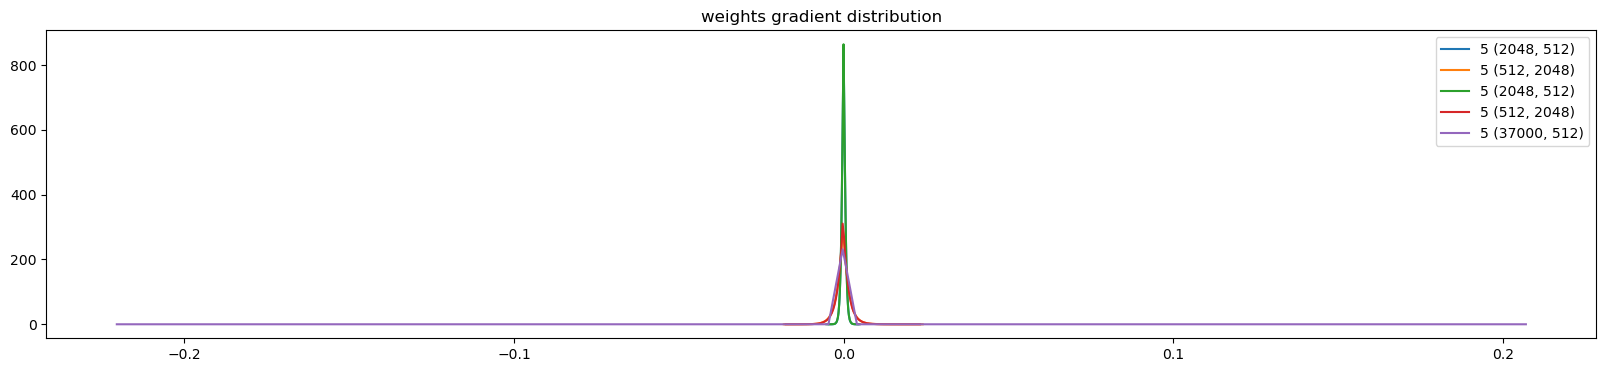

In [36]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.ff.output_projection.weight", "decoder.layers.5.ff.input_projection.weight", "decoder.layers.0.ff.input_projection.weight", "decoder.layers.0.ff.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(param.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


In [4]:
from training import overfit_one_batch
batch = next(iter(train_loader))
logs, diffs = overfit_one_batch(model, batch, optim, scheduler, conf, output_log=False, save_update_ratio=True)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Start overfitting in one batch!


  7%|█████▌                                                                             | 1/15 [00:01<00:24,  1.72s/it]

tensor(6.2476e-06)
{'embeddings': [-5.204285144805908]}


 13%|███████████                                                                        | 2/15 [00:03<00:22,  1.71s/it]

tensor(1.2270e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215]}


 20%|████████████████▌                                                                  | 3/15 [00:05<00:21,  1.78s/it]

tensor(1.8292e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215]}


 27%|██████████████████████▏                                                            | 4/15 [00:07<00:19,  1.80s/it]

tensor(2.4332e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611]}


 33%|███████████████████████████▋                                                       | 5/15 [00:09<00:18,  1.84s/it]

tensor(3.0369e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254]}


 40%|█████████████████████████████████▏                                                 | 6/15 [00:10<00:16,  1.84s/it]

tensor(3.6423e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834]}


 47%|██████████████████████████████████████▋                                            | 7/15 [00:12<00:15,  1.91s/it]

tensor(4.2469e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465]}


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:14<00:13,  1.90s/it]

tensor(4.8494e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014]}


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:16<00:11,  1.92s/it]

tensor(5.4556e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209]}


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:18<00:09,  1.96s/it]

tensor(6.0555e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154]}


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:20<00:07,  1.96s/it]

tensor(6.6589e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154, -4.1765947341918945]}


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:22<00:05,  1.95s/it]

tensor(7.2632e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154, -4.1765947341918945, -4.138874053955078]}


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:24<00:03,  1.96s/it]

tensor(7.8673e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154, -4.1765947341918945, -4.138874053955078, -4.1041741371154785]}


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:26<00:01,  1.99s/it]

tensor(8.4710e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154, -4.1765947341918945, -4.138874053955078, -4.1041741371154785, -4.072065353393555]}


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.91s/it]

tensor(9.0762e-05)
{'embeddings': [-5.204285144805908, -4.911139488220215, -4.7377448081970215, -4.613819599151611, -4.517563819885254, -4.438626766204834, -4.3719305992126465, -4.314311504364014, -4.26315975189209, -4.217849254608154, -4.1765947341918945, -4.138874053955078, -4.1041741371154785, -4.072065353393555, -4.0420966148376465]}


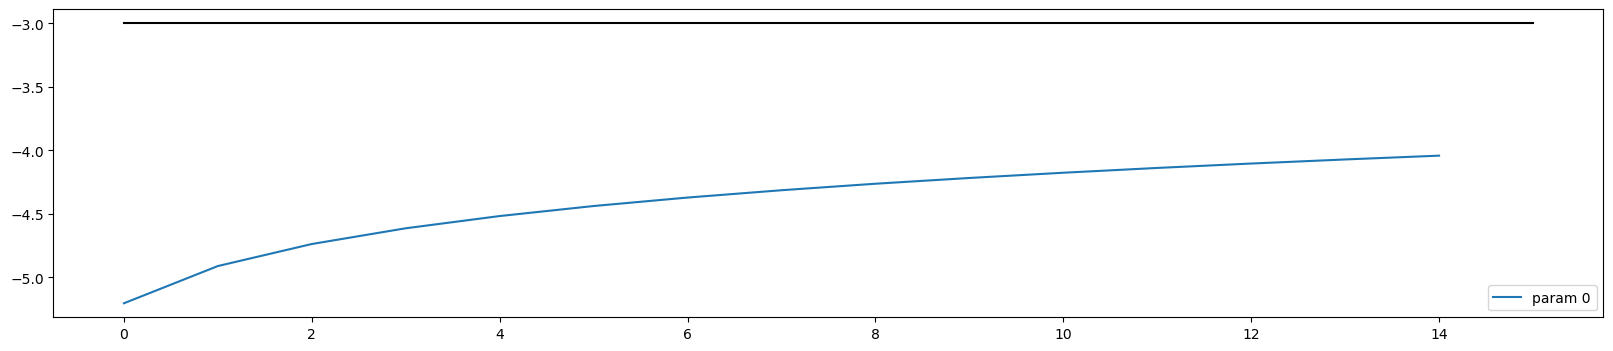

In [6]:

plt.figure(figsize=(20, 4))
legends = []
for i, (key, values) in enumerate(diffs.items()):
    plt.plot([values[i] for i in range(len(values))])
    legends.append('param %d' % i)
plt.plot([0, len(values)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


### Test on not failed model

In [8]:
from util.prepare_model import prepare_test, get_update_ratio

model, tokenizer = prepare_test(conf)

In [9]:
text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
print(inputs)
inputs = {k: v.to(conf.train.device) for k, v in inputs.items()}
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
target_tokens = {k: v.to(conf.train.device) for k, v in target_tokens.items()}
print(target_tokens["input_ids"][0][0])


{'input_ids': tensor([[    1,   566,   189,   213,    13,   189,   103,  2239,   235,  5664,
          5352,  2206,    60,  4912,  8874,    84, 18742,   155,  5068,   347,
           151,   137,  1855, 34659,   121,   189,   180,  3385,  2206,   151,
           624,   355,   155,  8573,   565,  2297,  7098,   276,   148,   137,
          1855, 34659,    15,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor(1)


In [11]:
import torch

model.train()
logits, loss, last_hidden_states, attentions_array, activations_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True, output_activation_state=True)
print(loss)
loss.backward()

tensor(9.1391, grad_fn=<AddBackward0>)


layer 0 (      ReLU): mean +0.18, std 0.36, saturated: 64.70%
layer 1 (      ReLU): mean +0.17, std 0.34, saturated: 65.96%
layer 2 (      ReLU): mean +0.11, std 0.27, saturated: 76.55%
layer 3 (      ReLU): mean +0.09, std 0.26, saturated: 78.90%
layer 4 (      ReLU): mean +0.12, std 0.30, saturated: 75.32%
layer 5 (      ReLU): mean +0.13, std 0.29, saturated: 72.85%


Text(0.5, 1.0, 'activation distribution')

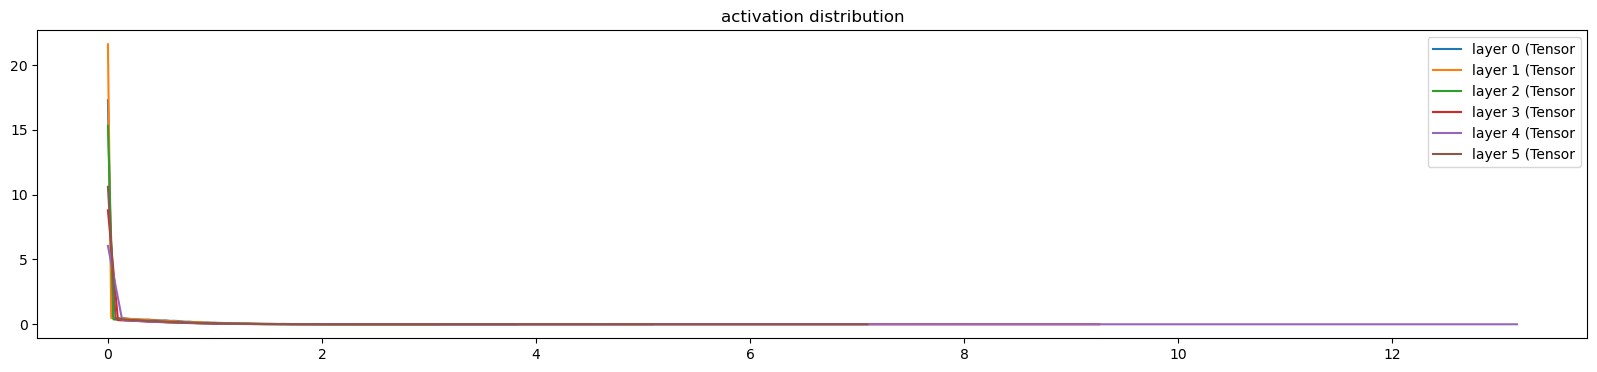

In [14]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(activations_array): # note: exclude the output layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "ReLU", layer.mean(),layer.std(), (layer.abs() == 0.00).float().mean()*100))
    hy, hx = torch.histogram(layer, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

We can see that compared with the initial values, the much more values are negative so get 0 gradient, but the remaining 25% still has gradient so the neuron is not dead.

weight (512, 512) | mean -0.000004 | std 6.416415e-03 | grad:data ratio 5.947583e-01
weight (512, 512) | mean +0.000002 | std 5.761900e-03 | grad:data ratio 3.668596e-01
weight (512, 512) | mean +0.000001 | std 7.293994e-03 | grad:data ratio 4.769749e-01
weight (37000, 512) | mean +0.000000 | std 1.773474e-03 | grad:data ratio 5.464026e-02


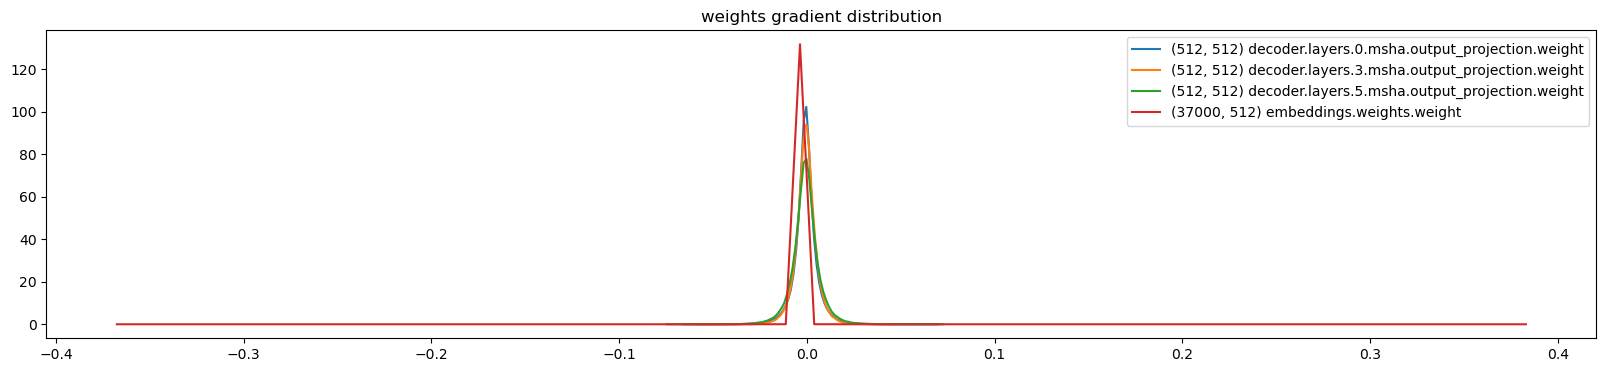

In [15]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.msha.output_projection.weight",  "decoder.layers.3.msha.output_projection.weight",  "decoder.layers.0.msha.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{tuple(param.shape)} {name}')
plt.legend(legends)
plt.title('weights gradient distribution');

weight (2048, 512) | mean -0.000000 | std 1.573058e-03 | grad:data ratio 5.347051e-02
weight (512, 2048) | mean +0.000000 | std 2.410550e-03 | grad:data ratio 2.158618e-01
weight (2048, 512) | mean -0.000000 | std 2.478331e-03 | grad:data ratio 8.290733e-02
weight (512, 2048) | mean -0.000010 | std 2.573858e-03 | grad:data ratio 2.003324e-01
weight (37000, 512) | mean +0.000000 | std 1.773474e-03 | grad:data ratio 5.464026e-02


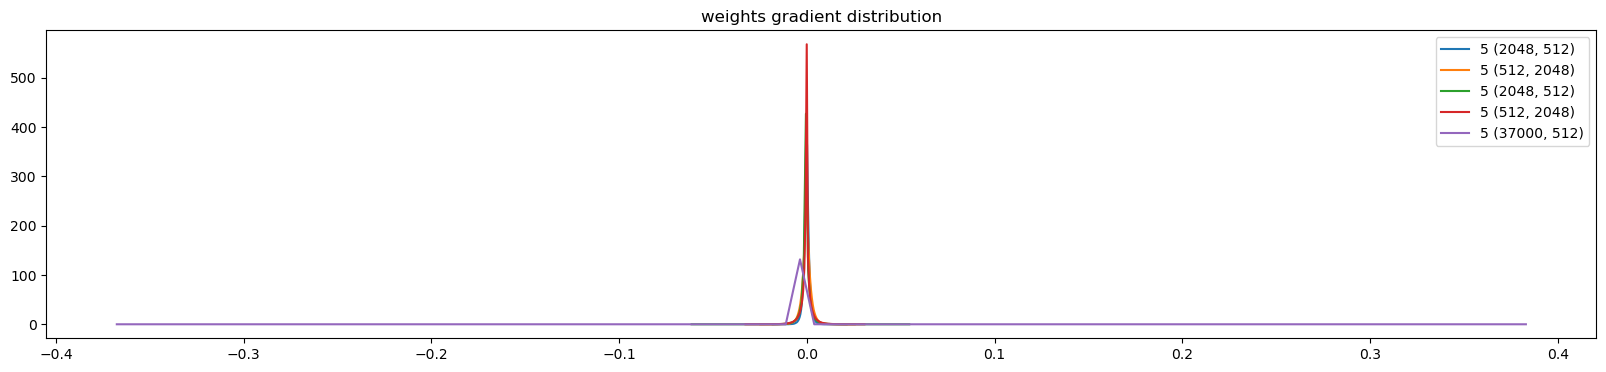

In [16]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.ff.output_projection.weight", "decoder.layers.5.ff.input_projection.weight", "decoder.layers.0.ff.input_projection.weight", "decoder.layers.0.ff.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(param.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


Gradients are really similar to the one in the initialization. We can see that after training the model is still well behaved.
## Failed model

In [3]:
from util.prepare_model import prepare_test, get_update_ratio

model, tokenizer = prepare_test(conf)

In [4]:
import torch

text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
print(inputs)
inputs = {k: v.to(conf.train.device) for k, v in inputs.items()}
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt", return_token_type_ids=False)
target_tokens = {k: v.to(conf.train.device) for k, v in target_tokens.items()}
print(target_tokens["input_ids"][0][0])


model.train()
logits, loss, last_hidden_states, attentions_array, activations_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True, output_activation_state=True)
print(loss)
loss.backward()

{'input_ids': tensor([[    1,   566,   189,   213,    13,   189,   103,  2239,   235,  5664,
          5352,  2206,    60,  4912,  8874,    84, 18742,   155,  5068,   347,
           151,   137,  1855, 34659,   121,   189,   180,  3385,  2206,   151,
           624,   355,   155,  8573,   565,  2297,  7098,   276,   148,   137,
          1855, 34659,    15,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor(1)
tensor(9.9702, grad_fn=<AddBackward0>)


layer 0 (      ReLU): mean +0.28, std 0.56, saturated: 66.97%
layer 1 (      ReLU): mean +0.66, std 1.01, saturated: 52.05%
layer 2 (      ReLU): mean +0.48, std 0.91, saturated: 63.72%
layer 3 (      ReLU): mean +0.49, std 0.85, saturated: 58.55%
layer 4 (      ReLU): mean +1.48, std 3.39, saturated: 72.85%
layer 5 (      ReLU): mean +3.97, std 12.72, saturated: 87.48%


Text(0.5, 1.0, 'activation distribution')

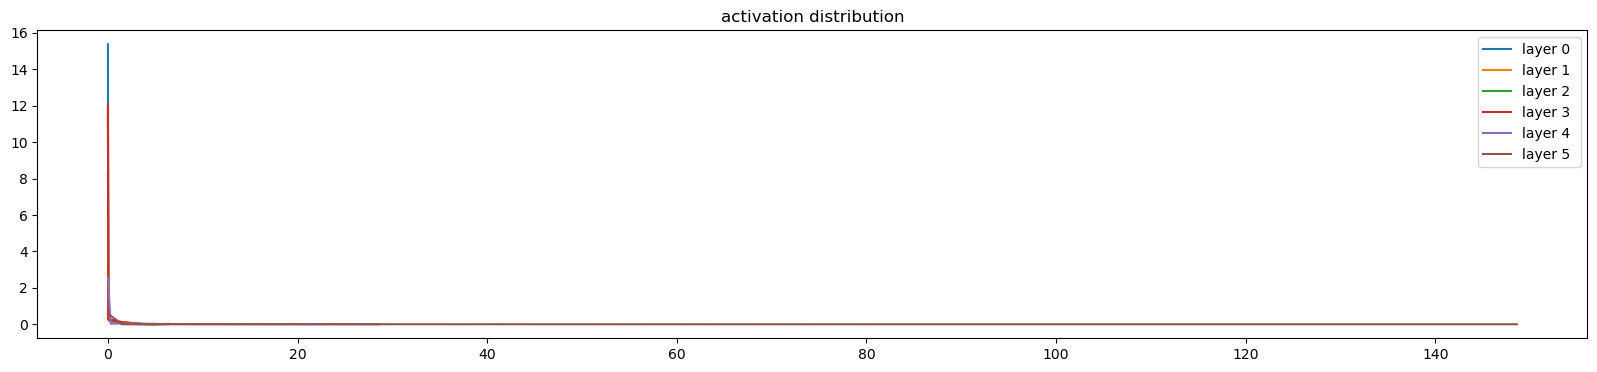

In [10]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(activations_array): # note: exclude the output layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "ReLU", layer.mean(),layer.std(), (layer.abs() == 0.00).float().mean()*100))
    hy, hx = torch.histogram(layer, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ')
plt.legend(legends);
plt.title('activation distribution')

We can compare the means and stds to the not failed model and it is clear that some values have exploded. In the good case std doesn't reach 1 and mean is at most 0.18, while in the failed case the values in the last layers are huge, as these values are huge they don't let the gradient go through the values of the layers before so the problem is in the last 2 layers.

weight (512, 512) | mean -0.000000 | std 3.713137e-14 | grad:data ratio 3.843939e-12
weight (512, 512) | mean -0.000000 | std 2.156260e-12 | grad:data ratio 2.146247e-10
weight (512, 512) | mean +0.000000 | std 5.464930e-06 | grad:data ratio 9.979890e-05
weight (37000, 512) | mean +0.000000 | std 8.625567e-04 | grad:data ratio 1.587840e-03


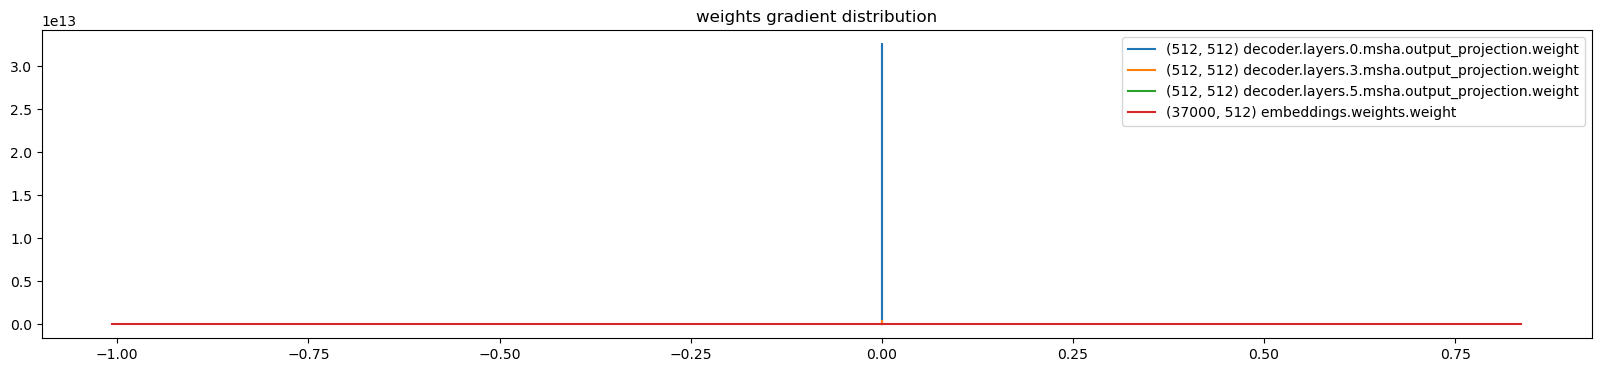

In [6]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.msha.output_projection.weight",  "decoder.layers.3.msha.output_projection.weight",  "decoder.layers.0.msha.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{tuple(param.shape)} {name}')
plt.legend(legends)
plt.title('weights gradient distribution');

weight (2048, 512) | mean +0.000000 | std 4.532508e-15 | grad:data ratio 1.575680e-13
weight (512, 2048) | mean -0.000000 | std 4.309217e-15 | grad:data ratio 3.914863e-13
weight (2048, 512) | mean +0.000000 | std 3.868013e-05 | grad:data ratio 2.086557e-05
weight (512, 2048) | mean -0.000001 | std 4.994808e-04 | grad:data ratio 3.101666e-04
weight (37000, 512) | mean +0.000000 | std 8.625567e-04 | grad:data ratio 1.587840e-03


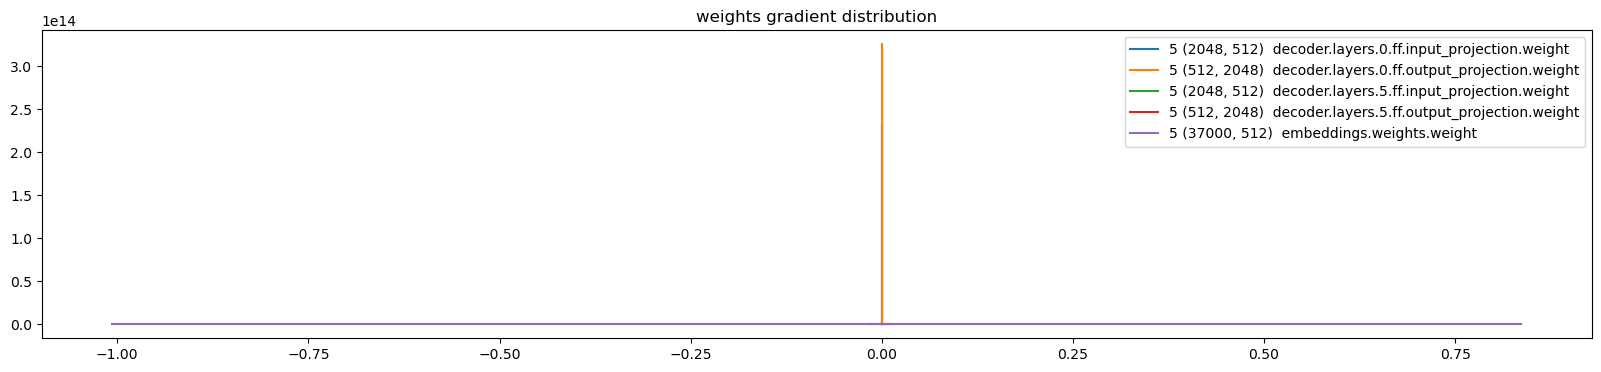

In [11]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
layers = ["embeddings.weights.weight", "decoder.layers.5.ff.output_projection.weight", "decoder.layers.5.ff.input_projection.weight", "decoder.layers.0.ff.input_projection.weight", "decoder.layers.0.ff.output_projection.weight", ]

for name, param in model.named_parameters():
  t = param.grad
  if name in layers:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(param.shape)}  {name}')
plt.legend(legends)
plt.title('weights gradient distribution');


The gradient graph is completely centered, the std of some layers is too high, that is that those gradient are always almost 0 so parameters don't get updated. The gradient vanishis and only affects the last layers, in the msha it is the same, the 0 and 3 layer have almost no gradient while the lm_head and the last layer still have decent values.

Comparing the not failed version, it is clear that in that case all the layers are getting at least some gradient flowing. On the contrary, the failed model has broken so gradient can't reach the layers at the top, then the model can't learn properly as only a small fraction of the parameters get changed.

# LR schedulers

In [1]:
import sys

sys.path.insert(0, r"PATH") 

import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
import omegaconf
path = r"PATH"
conf = omegaconf.OmegaConf.load(path)

In [3]:
from util.prepara_data import prepare_data
from util.prepare_model import prepare_training, get_update_ratio

warmup_steps = int(conf.train.steps*(20/100))
lr_list = [1e-2, 1e-3, 5e-3, 1e-4]
conf.train.device = "cpu"

scheduler_list = []
for j in range(len(lr_list)):
    conf.train.warmup_steps = warmup_steps
    conf.train.lr = lr_list[j]
    print(f"Warmup steps: {warmup_steps} and Max lr: {lr_list[j]}")
    _, _, optim, scheduler = prepare_training(conf)
    scheduler_list.append(scheduler)
print(len(scheduler_list))

Warmup steps: 400 and Max lr: 0.01
Model loaded
Optim loaded
Warmup steps: 400 and Max lr: 0.001
Model loaded
Optim loaded
Warmup steps: 400 and Max lr: 0.005
Model loaded
Optim loaded
Warmup steps: 400 and Max lr: 0.0001
Model loaded
Optim loaded
4


4 1999
[0.001, 0.0010225, 0.001045, 0.0010674999999999999, 0.0010899999999999998, 0.0011124999999999998, 0.0011349999999999997, 0.0011574999999999997, 0.0011799999999999996, 0.0012024999999999998]


C:\Users\Victor\miniforge3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\Victor\miniforge3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replic

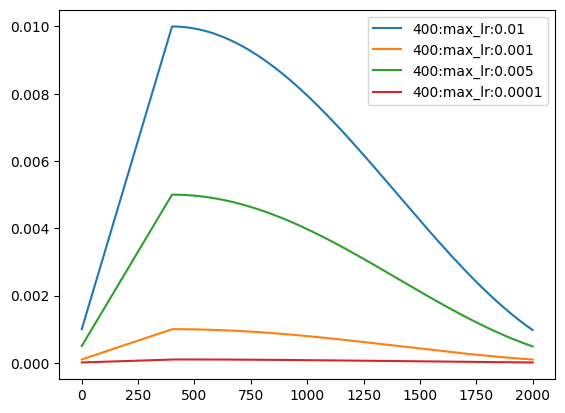

In [4]:
import numpy as np

lrs = []
for scheduler in scheduler_list:
    actual_rl = []
    for i in range(1, conf.train.steps):
        actual_rl.append(scheduler.state_dict()['_last_lr'][0])
        scheduler.step()
    lrs.append(actual_rl)
print(len(lrs), len(lrs[0]))
print(lrs[0][:10])

for i in range(len(lrs)):
    plt.plot(np.arange(1, conf.train.steps), lrs[i])

plt.legend([f"{warmup_steps}:max_lr:{lr_list[0]}", f"{warmup_steps}:max_lr:{lr_list[1]}", 
            f"{warmup_steps}:max_lr:{lr_list[2]}", f"{warmup_steps}:max_lr:{lr_list[3]}"])
plt.show()


Max lr: 0.0001


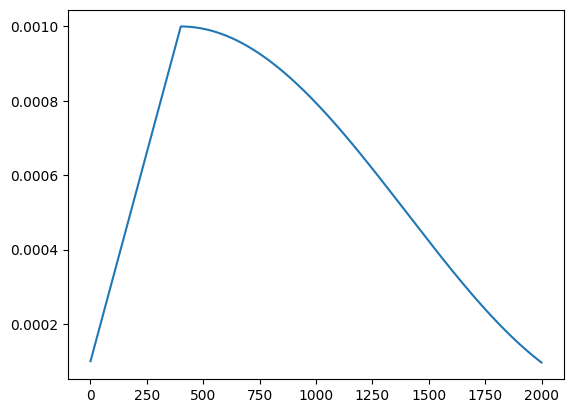

In [13]:
import torch
print(f"Max lr: {conf.train.lr}")
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optim, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=conf.train.steps, eta_min=conf.train.lr/1e3)
scheduler =  torch.optim.lr_scheduler.SequentialLR(optim, schedulers=[scheduler_warmup, scheduler_cosine], milestones=[conf.train.warmup_steps])

actual_rl = []
for i in range(1, conf.train.steps):
    actual_rl.append(scheduler.state_dict()['_last_lr'][0])
    scheduler.step()

plt.plot(np.arange(1, conf.train.steps), actual_rl)
plt.show()


Max lr: 0.0001


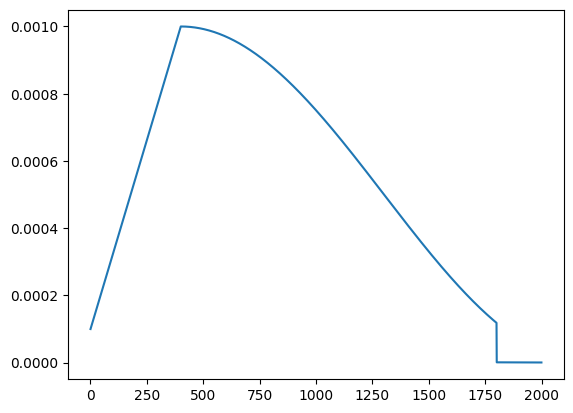

In [14]:
import torch
print(f"Max lr: {conf.train.lr}")
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optim, start_factor=0.1, end_factor=1.0, total_iters=conf.train.warmup_steps)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=int(conf.train.steps*0.9), eta_min=conf.train.lr*1e-2)
# we end the cosine at lr*1e-3 so we start the dacay by a factor of that lr, if we max is 2e-3 then we start the decay at 2e-6
scheduler_decay = torch.optim.lr_scheduler.LinearLR(optim, start_factor=1e-3, end_factor=1e-4, total_iters=conf.train.warmup_steps)
scheduler =  torch.optim.lr_scheduler.SequentialLR(optim, schedulers=[scheduler_warmup, scheduler_cosine, scheduler_decay], 
                                                   milestones=[conf.train.warmup_steps, int(conf.train.steps*0.9)])

actual_rl = []
for i in range(1, conf.train.steps):
    actual_rl.append(scheduler.state_dict()['_last_lr'][0])
    scheduler.step()

plt.plot(np.arange(1, conf.train.steps), actual_rl)
plt.show()


In [19]:
actual_rl[-10:]

[1.0152910305757686e-05,
 1.0105751308569813e-05,
 1.0058690869844815e-05,
 1.0011729105699678e-05,
 9.964866132007912e-06,
 9.918102064399196e-06,
 9.87143701825925e-06,
 9.824871108729432e-06,
 9.77840445070648e-06,
 9.732037158842287e-06]

In [7]:
import pandas as pd

df = pd.read_csv(r"PATH")
df

,losses,gradient_norm,learning_rate,warmup,max_lr
0,7.439750,13.532606,0.000100,100,0.0100
1,6.214351,3.163399,0.000109,100,0.0100
2,5.912670,2.469642,0.000118,100,0.0100
3,5.704174,2.082427,0.000127,100,0.0100
4,5.606667,4.652559,0.000136,100,0.0100
...,...,...,...,...,...
2644,1.399749,0.057703,0.000350,500,0.0001
2645,1.399312,0.059300,0.000352,500,0.0001
2646,1.398923,0.064073,0.000354,500,0.0001
2647,1.398200,0.049984,0.000356,500,0.0001


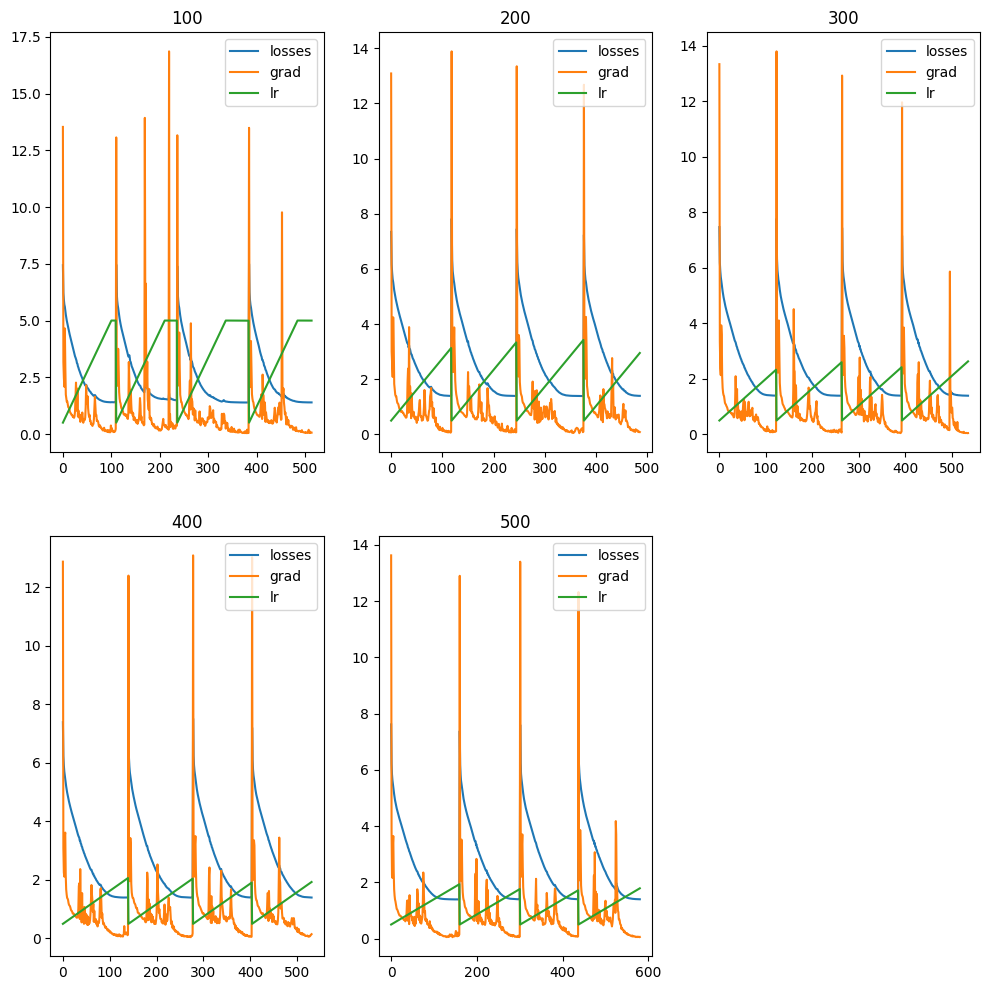

In [16]:
fig = plt.figure(figsize=(12, 12))
# for i in range(6):
#     ax = fig.add_subplot(2, 3, i+1)
#     ax.imshow(image[i])
#     ax.axis("off")

for i, warmup in enumerate(set(df["warmup"])):
    ax = fig.add_subplot(2, 3, i+1)
    x = np.arange(len(df[df["warmup"]==warmup]["losses"]))
    ax.plot(x, df[df["warmup"]==warmup]["losses"], label="losses")
    ax.plot(x, df[df["warmup"]==warmup]["gradient_norm"], label="grad")
    ax.plot(x, df[df["warmup"]==warmup]["learning_rate"]*5000,  label='lr')

    ax.set_title(f"{warmup}")
    ax.legend()

plt.legend()
plt.show()

In [11]:
import pandas as pd

df = pd.read_csv(r"PATH")
df

,losses,gradient_norm,learning_rate,warmup,max_lr
0,7.439750,13.532606,0.000200,100,0.002
1,6.055643,2.488085,0.000218,100,0.002
2,5.712601,3.933789,0.000236,100,0.002
3,5.391702,1.898251,0.000254,100,0.002
4,5.166797,1.678294,0.000272,100,0.002
...,...,...,...,...,...
245,4.330814,0.138022,0.001613,100,0.002
246,4.330249,0.148926,0.001608,100,0.002
247,4.322834,0.109499,0.001603,100,0.002
248,4.328737,0.179254,0.001598,100,0.002


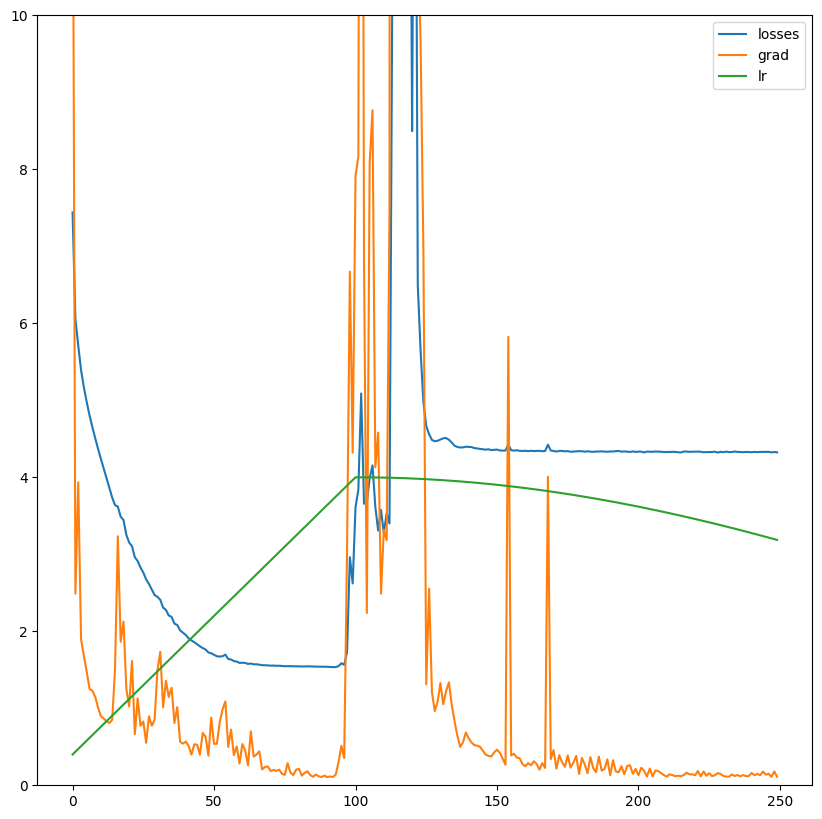

In [12]:
import numpy as np

fig = plt.figure(figsize=(10, 10))
x = np.arange(len(df["losses"]))
plt.plot(x, df["losses"], label="losses")
plt.plot(x, df["gradient_norm"], label="grad")
plt.plot(x, df["learning_rate"]*2000,  label='lr')
ax = plt.gca()

ax.set_ylim(ymin=0, ymax=10)

plt.legend()
plt.show()